# Table of Contents

- [Data Collection and Loading](#Loading)
    - [Imports](#Imports)
    - [Dataset Loading](#Loading)
    - [API Standardization](#API)
    - [Data Quality Assessment](#Quality)
    - [Individual Column Assessment](#Column)
        - [Well Production](#Prod)
        - [Well Properties](#Properties)
        - [Well Formations](#Formations)
- [Data Quality Assessment and Cleaning](#Clean)
    - [Understanding Production Units and Data Context](#Units)
    - [Time Series Analysis and Spike Period Assessment](#Spike)
    - [Production Patterns and Zero Values](#ProdPatterns)
    - [Production Month Validation and Gap Analysis](#Gap)
    - [Geospatial Coordinate Validation](#Geospatial)
    - [Operator Performance and Size Analysis](#Operator)
    - [Formation Name Standardization](#Formation)

## Data Collection and Loading <a id="Loading"></a>

### Imports <a id="Imports"></a>

In [1]:
#libraries for data collection and loading
import pandas as pd
import numpy as np
import geopandas as gpd

#support libraries
from datetime import datetime
import re

#display settings for pandas output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

### Dataset Loading <a id="Loading"></a>

In [2]:
def load_parquet_datasets(file_paths):
    """
    Load multiple parquet files with error handling and initial inspection.
    
    Args:
        file_paths (dict): Dictionary with dataset names as keys and file paths as values
        
    Returns:
        dict: Dictionary containing loaded DataFrames
    """
    datasets = {}
    
    for name, path in file_paths.items():
        try:
            df = pd.read_parquet(path)
            print(f"  Successfully loaded {name} with pandas")
            print(f"  Shape: {df.shape}")
            datasets[name] = df
            
        except Exception as e:
            print(f"✗ Failed to load {name}: {str(e)}")
            
    return datasets

In [3]:
file_paths = {
    'well_production': '../data/ds_interview_well_prod.parquet',
    'well_properties': '../data/ds_interview_well_props.parquet', 
    'well_formations': '../data/ds_interview_formations.parquet'
}

file_paths

{'well_production': '../data/ds_interview_well_prod.parquet',
 'well_properties': '../data/ds_interview_well_props.parquet',
 'well_formations': '../data/ds_interview_formations.parquet'}

In [4]:
raw_datasets = load_parquet_datasets(file_paths)

raw_datasets

  Successfully loaded well_production with pandas
  Shape: (17724875, 9)
  Successfully loaded well_properties with pandas
  Shape: (430661, 19)
  Successfully loaded well_formations with pandas
  Shape: (382132, 3)


{'well_production':           date_prod   api_no_10  gas_monthly  oil_monthly  production_month  \
 0        2024-05-01  4218385145        450.0        238.0               108   
 1        2022-04-01  4213534842         35.0         27.0               352   
 2        2024-06-01  4218700792          0.0          1.0               244   
 3        2023-05-01  4200342397        357.0         37.0               124   
 4        2021-05-01  4240135173          0.0          0.0               116   
 ...             ...         ...          ...          ...               ...   
 17724870 2021-01-01  4247581581          2.0         35.0               337   
 17724871 2024-01-01  4250533767       3212.0          0.0               310   
 17724872 2022-06-01  4218331486       1433.0         18.0               245   
 17724873 2024-06-01  4243930536          0.0          0.0               257   
 17724874 2022-09-01  4229105462          2.0          1.0               355   
 
           start_da

In [5]:
raw_datasets['well_production'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17724875 entries, 0 to 17724874
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date_prod         datetime64[ms]
 1   api_no_10         object        
 2   gas_monthly       float64       
 3   oil_monthly       float64       
 4   production_month  int64         
 5   start_date        object        
 6   county            object        
 7   sub_region        object        
 8   region            object        
dtypes: datetime64[ms](1), float64(2), int64(1), object(5)
memory usage: 1.2+ GB


The data types seem to match the columns mostly well:
- we have a datetime column that could serve as the later index
- gas and oil being floats makes sense
- production month works as an integer
- api number, country, sub_region and region all make sense as strings
- start_date might make more sense as a datetime object but we'll see how we'll use it

There aren't any obvious null values either but we'll have to explore that more closely

In [6]:
raw_datasets['well_properties'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430661 entries, 0 to 430660
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   api_no_10          430661 non-null  object 
 1   operator_name      430657 non-null  object 
 2   lon_surface        428394 non-null  float64
 3   lat_surface        428394 non-null  float64
 4   lon_bottomhole     428382 non-null  object 
 5   lat_bottomhole     428382 non-null  object 
 6   elevation_ground   0 non-null       object 
 7   depth_tvd          32733 non-null   float64
 8   lower_perf         0 non-null       object 
 9   upper_perf         0 non-null       object 
 10  measured_depth     391995 non-null  object 
 11  horizontal_length  102008 non-null  float64
 12  wellbore_type      428462 non-null  object 
 13  field_name         429374 non-null  object 
 14  township           0 non-null       object 
 15  section            0 non-null       object 
 16  ra

Here there are a lot of empty columns:
- elevation_ground, lower_perf, upper_perf, township, section and range
    - with no values at all I'm not sure how we'd use these, but we can explore if they would be very helpful later, otherwise we probably won't worry about them for now
    - I doubt things like township or section would ever be helpful because they seem like conventional human borders, we're studying natural wells and rock formations, etc.

Here are some more meanings for some of the less obvious parameters:
- elevation_ground: the elevation of the ground surface at the wellhead location. It's a type of elevation (EL) used in the oil and gas industry to help determine the well's depth relative to the surface and the target formation, influencing factors like the length of the drill string
- depth_tvd: True Vertical Depth. It refers to the vertical distance from a reference point at the surface (often the rotary kelly bushing (RKB) or wellhead) to a point in the wellbore. Unlike measured depth (MD), which follows the path of the wellbore, TVD is the straight, vertical distance. It is a critical parameter for:
    - Reservoir characterization: Helping geologists understand the depth of the reservoir and its properties.
    - Drilling and completion: Informing well planning and completion designs, like the placement of perforations.
    - Production optimization: Assisting in estimating fluid flow rates and pressure gradients.
    - Wellbore stability: Helping assess potential instability due to rock stresses and pore pressure.
- lower_perf and upper_perf: These likely represent the measured depths (MD) of the lower and upper perforation points, respectively, within the wellbore. Perforations are holes made in the well casing and cement to allow hydrocarbons (oil and gas) to flow from the formation into the wellbore for production.
    - Upper Perf: The measured depth to the top perforation in the perforated interval.
    - Lower Perf: The measured depth to the lowest interval in the perforated interval.

It might be possible to calculate elevation ground using geospatial tools, but upper perf and lower perf would likely to be difficult to calculate without being told, unless the api number is associated with some highly specific tools that would have standardized values for how far apart they are or something like that

...

api number and county name seem to be the only fields where there are no (obvious) null values, other columns have null values of varying amounts
- We will need to check whether the api values are standardized throughout the datasets, so we'll investigate that column in all 3 datasets before moving on

Some null values might make sense, such as horizontal_length being null for a conventional vertical drilling methods, we'll need to think of how to handle that (can forecast different types of drills separately for example, or just make the feature 0 in the case of vertical drill)

The only other column with a lot of null values (relatively speaking compared to the total) is depth_tvd, I wonder if it's possible to derive that value from knowing the differences in lat/lon at the surface and bottom, combined with the measured depth (we could even check our measurement on existing values for these parameters)

The other null values seem to be a very low percentage of the column, so it might be more happenstance, but we should also check whether null values in one column co-occur with null values in another

...

About data types, some of the missing columns don't make sense but that doesn't matter yet

Lat, lon and measured depth should be numbers, not object/string

In [7]:
raw_datasets['well_formations'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382132 entries, 0 to 382131
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   api_no_10  382132 non-null  object
 1   formation  382132 non-null  object
 2   basin      382132 non-null  object
dtypes: object(3)
memory usage: 8.7+ MB


In this case we have no (apparent) missing data and the column types all make sense, so I don't think there is anything to worry about here yet

For now, we need to explore the API columns and make sure their format is appropriately standardized

### API Standardization <a id="API"></a>

In [8]:
raw_datasets['well_production']['api_no_10'].head()

0    4218385145
1    4213534842
2    4218700792
3    4200342397
4    4240135173
Name: api_no_10, dtype: object

In [9]:
raw_datasets['well_production']['api_no_10'].tail()

17724870    4247581581
17724871    4250533767
17724872    4218331486
17724873    4243930536
17724874    4229105462
Name: api_no_10, dtype: object

In [10]:
raw_datasets['well_properties']['api_no_10'].head()

0    4242131075
1    4243934705
2    4239530630
3    4225130640
4    4204131998
Name: api_no_10, dtype: object

In [11]:
raw_datasets['well_properties']['api_no_10'].tail()

430656    4231134458
430657    4222736804
430658    4222739543
430659    4236500943
430660    4248380185
Name: api_no_10, dtype: object

In [12]:
raw_datasets['well_formations']['api_no_10'].head()

0    4243936095
1    4210500728
2    4202934580
3    4210532959
4    4216530509
Name: api_no_10, dtype: object

In [13]:
raw_datasets['well_formations']['api_no_10'].tail()

382127    4232935868
382128    4250732348
382129    4228334858
382130    4200346398
382131    4238301165
Name: api_no_10, dtype: object

The format seems to be a 10 digit number, starting with 42 (which as I learned from my research, is associated with Texas). We need to confirm that this format is universal across the datasets, for properly working join operations.

In [8]:
api_pattern = r'^42\d{8}$'

api_pattern

'^42\\d{8}$'

In [9]:
invalid_api_numbers_production = raw_datasets['well_production'][~raw_datasets['well_production']['api_no_10'].str.contains(api_pattern, na=False)]

invalid_api_numbers_production

,date_prod,api_no_10,gas_monthly,oil_monthly,production_month,start_date,county,sub_region,region
275,1996-11-01,4903520816,1058826.0,0.0,120,1986-12-01,SUBLETTE,Wyoming,west
2553,2010-03-01,4903520815,693243.0,0.0,281,1986-11-01,SUBLETTE,Wyoming,west
5088,2020-08-01,4903520816,0.0,0.0,405,1986-12-01,SUBLETTE,Wyoming,west
6815,2019-01-01,4903520815,846197.0,0.0,387,1986-11-01,SUBLETTE,Wyoming,west
12701,1996-04-01,4903520871,1229301.0,0.0,122,1986-03-01,SUBLETTE,Wyoming,west
...,...,...,...,...,...,...,...,...,...
17694594,1991-04-01,4903520858,0.0,0.0,65,1985-12-01,SUBLETTE,Wyoming,west
17695519,1997-01-01,4903520816,898777.0,0.0,122,1986-12-01,SUBLETTE,Wyoming,west
17699560,1987-04-01,4903520862,698886.0,0.0,10,1986-07-01,SUBLETTE,Wyoming,west
17708059,2000-04-01,4903520816,0.0,0.0,161,1986-12-01,SUBLETTE,Wyoming,west


There are a fair few invalid api numbers, and from a superficial inspection, all seem to be from the state of Wyoming, so let's check if all of them are (if so, we can simply drop this subset since we are focused on Texas)

In [16]:
invalid_api_numbers_production['sub_region'].value_counts()

sub_region
Wyoming    2792
Name: count, dtype: int64

Our suspicion was confirmed, so let's just drop this data:

In [10]:
raw_datasets['well_production'] = raw_datasets['well_production'][raw_datasets['well_production']['api_no_10'].str.contains(api_pattern, na=False)].copy()
raw_datasets['well_production'].shape

(17722083, 9)

17724875-17722083=2792, so that checks out

In [11]:
invalid_api_numbers_properties = raw_datasets['well_properties'][~raw_datasets['well_properties']['api_no_10'].str.contains(api_pattern, na=False)]

invalid_api_numbers_properties

,api_no_10,operator_name,lon_surface,lat_surface,lon_bottomhole,lat_bottomhole,elevation_ground,depth_tvd,lower_perf,upper_perf,measured_depth,horizontal_length,wellbore_type,field_name,township,section,range,county_name,sub_region


No problems there, so let's check the formations:

In [12]:
invalid_api_numbers_formations = raw_datasets['well_formations'][~raw_datasets['well_formations']['api_no_10'].str.contains(api_pattern, na=False)]

invalid_api_numbers_formations

,api_no_10,formation,basin


In that case, we've done what we can to ensure that the wells have a standardized API number for all future join operations that will need an index.

Now let's get into scoping out more comprehensive data definitions:

### Data Quality Assessment <a id="Quality"></a>

In [42]:
def comprehensive_data_overview(datasets):
    """
    Provide comprehensive overview of all datasets including data types,
    missing values, and basic statistics.
    
    Args:
        datasets (dict): Dictionary of DataFrames to analyze
    """
    for name, df in datasets.items():
        print(f"\n{'='*60}")
        print(f"DATASET: {name.upper()}")
        print(f"{'='*60}")
        
        # Shape
        print(f"Shape: {df.shape}")
        
        # Column information
        print(f"\nColumn Overview:")
        print(f"{'Column':<25} {'Type':<15} {'Non-Null':<10} {'Unique':<10} {'Missing %':<10}")
        print("-" * 80)
        
        for col in df.columns:
            dtype = str(df[col].dtype)
            non_null = df[col].count()
            unique_count = df[col].nunique()
            missing_pct = (df[col].isnull().sum() / len(df)) * 100
            
            print(f"{col:<25} {dtype:<15} {non_null:<10} {unique_count:<10} {missing_pct:<10.1f}%")
        
        # Date/time columns detection
        potential_date_cols = [col for col in df.columns if 
                              any(keyword in col.lower() for keyword in 
                                  ['date', 'time', 'year', 'month', 'spud', 'completion'])]
        if potential_date_cols:
            print(f"\nPotential date/time columns: {potential_date_cols}")
            
        # Coordinate columns detection
        coord_cols = [col for col in df.columns if 
                     any(keyword in col.lower() for keyword in 
                         ['lat', 'lon', 'longitude', 'latitude', 'surface', 'bottom'])]
        if coord_cols:
            print(f"\nCoordinate columns: {coord_cols}")
        
        # Production-related columns (for well_production dataset)
        if 'production' in name.lower():
            prod_cols = [col for col in df.columns if 
                        any(keyword in col.lower() for keyword in 
                            ['oil', 'gas', 'water', 'bbl', 'mcf', 'prod', 'volume'])]
            if prod_cols:
                print(f"\nProduction columns: {prod_cols}")
        
        # Formation-related columns (for well_formations dataset)
        if 'formation' in name.lower():
            form_cols = [col for col in df.columns if 
                        any(keyword in col.lower() for keyword in 
                            ['formation', 'zone', 'reservoir', 'rock', 'geology', 'basin'])]
            if form_cols:
                print(f"\nFormation columns: {form_cols}")
        
        # Well properties columns
        if 'properties' in name.lower() or 'props' in name.lower():
            prop_cols = [col for col in df.columns if 
                        any(keyword in col.lower() for keyword in 
                            ['depth', 'length', 'horizontal', 'vertical', 'lateral', 'completion', 'wellbore', 'field', 'county', 'region'])]
            if prop_cols:
                print(f"\nWell property columns: {prop_cols}")

In [27]:
comprehensive_data_overview(raw_datasets)


DATASET: WELL_PRODUCTION
Shape: (17722083, 9)

Column Overview:
Column                    Type            Non-Null   Unique     Missing % 
--------------------------------------------------------------------------------
date_prod                 datetime64[ms]  17722083   472        0.0       %
api_no_10                 object          17722083   430661     0.0       %
gas_monthly               float64         17722083   130811     0.0       %
oil_monthly               float64         17722083   38712      0.0       %
production_month          int64           17722083   473        0.0       %
start_date                object          17719431   387        0.0       %
county                    object          17722083   227        0.0       %
sub_region                object          17722083   5          0.0       %
region                    object          1320       1          100.0     %

Potential date/time columns: ['date_prod', 'gas_monthly', 'oil_monthly', 'production_month', '

Some notes and thoughts about the above that might be relevant later:

In general, there are more missing values that it seemed from .info(), because "is_null" seems to pick up more of them

WELL_PRODUCTION:
- Two columns have missing data, start_date (which has almost no data missing) and region (which has nearly all data missing), region likely doesn't matter because sub_region seems to indicate the state, which is the main large region boundary we are concerned with, so I can probably drop region and find a way to impute start_date (maybe based on the first dates I have for the wells in question, or based on other average patterns in the dataset, or something else)
- the data has 472 unique monthly values so that's most likely roughly 40 years of data

WELL_PROPERTIES:
- we already saw that most columns had at least a few missing values, so that's mostly not noteworthy
- I note that sub-region has 5 values though (with a tiny few missing), so we will want to make sure all of those are within Texas in addition to performing geospatial validation of the data (and that might help fill the missing data)
- operator name has a very high number of values, but not entirely unique (like a class with nearly 10000 values), there are probably too many classes in a feature like that to be useful, it would be good to look into clustering it based on relationship to targets, or even just to examine the unique values to see if a smaller portion dominates and there just turns out to be a lot of very small unique one's that don't matter much
- the same appplies to field name and somewhat to county_name, it is a class with a huge number of values, we need to narrow these classes down into fewer that contain more information
- we don't want to miss lat/lon values and we should also see if the missing values co-occur (same with measured_depth. and maybe also with depth_tvd but that one will be harder because it's almost entirely missing)
- horizontal length is mostly missing but that might make sense just based on the type of drilling being done so we'll need to investigate that, and indeed there are only 3 wellbore types so that feature will help us investigate it, so are missing but might be able to be imputed based on having other features like horizontal length or by comparing the production values to the wellbore types and seeing where they cluster

WELL_FORMATION:
- There are no missing values and the columns don't have too many features, so I should just investigate the classes a little more closely

...

Before moving on, I'll run one more comprehensive check for missing values and duplicates so we're in a good place to assess the rest of the data

In [43]:
def data_quality_assessment(datasets):
    """
    Comprehensive data quality assessment including missing values,
    duplicates, and data consistency checks.
    """
    quality_report = {}
    
    for name, df in datasets.items():
        print(f"\n{'='*50}")
        print(f"DATA QUALITY ASSESSMENT: {name.upper()}")
        print(f"{'='*50}")
        
        # Missing values analysis
        missing_data = df.isnull().sum()
        missing_pct = (missing_data / len(df)) * 100
        
        print("Missing Values Analysis:")
        print(f"{'Column':<25} {'Missing Count':<15} {'Missing %':<10}")
        print("-" * 50)
        
        for col in df.columns:
            miss_count = missing_data[col]
            miss_pct = missing_pct[col]
            if miss_count > 0:
                print(f"{col:<25} {miss_count:<15} {miss_pct:<10.1f}%")
        
        # Overall missing data summary
        total_missing = missing_data.sum()
        total_cells = df.shape[0] * df.shape[1]
        overall_missing_pct = (total_missing / total_cells) * 100
        
        print(f"\nOverall Missing Data Summary:")
        print(f"  Total missing cells: {total_missing:,}")
        print(f"  Total cells: {total_cells:,}")
        print(f"  Overall missing percentage: {overall_missing_pct:.2f}%")
        
        # Duplicate analysis
        total_duplicates = df.duplicated().sum()
        duplicate_pct = (total_duplicates / len(df)) * 100
        
        print(f"\nDuplicate Analysis:")
        print(f"  Total duplicate rows: {total_duplicates}")
        print(f"  Duplicate percentage: {duplicate_pct:.2f}%")
        
        # API-specific duplicate analysis if API columns exist
        api_cols = [col for col in df.columns if 'api' in col.lower()]
        if api_cols:
            api_col = api_cols[0]
            api_duplicates = df[api_col].duplicated().sum()
            print(f"  API number duplicates: {api_duplicates}")
        
        # Store quality metrics
        quality_report[name] = {
            'total_rows': len(df),
            'total_missing': total_missing,
            'missing_percentage': overall_missing_pct,
            'duplicate_rows': total_duplicates,
            'duplicate_percentage': duplicate_pct
        }
    
    return quality_report

In [29]:
quality_report = data_quality_assessment(raw_datasets)


DATA QUALITY ASSESSMENT: WELL_PRODUCTION
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
start_date                2652            0.0       %
region                    17720763        100.0     %

Overall Missing Data Summary:
  Total missing cells: 17,723,415
  Total cells: 159,498,747
  Overall missing percentage: 11.11%

Duplicate Analysis:
  Total duplicate rows: 0
  Duplicate percentage: 0.00%
  API number duplicates: 17291422

DATA QUALITY ASSESSMENT: WELL_PROPERTIES
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
operator_name             4               0.0       %
lon_surface               2267            0.5       %
lat_surface               2267            0.5       %
lon_bottomhole            2279            0.5       %
lat_bottomhole            2279            0.5       %
elevation_ground          430661        

There looks to be essentially no duplicate rows (the only thing that shows up duplicates in the api value is the production data but there should be duplicates there since it's time series data, it's looking at the same well throughout time)

Looking at the counts is helpful though since it provides hints about the co-occurence of missing values:
- lon and lat surface values have the same number of missing
- long and lat bottom also have the same
- the other are unique and don't tell us much by the value, so we'll need to investigate more closely to see if there are missing co-occurences which might inform our imputation strategy (except for the one's that are missing all of them but it's obvious that those would have identical counts)

So the last thing I'm going to do for this step of Data Wrangling is examining each individual feature, to better understand its values, its distribution, and any missing values it tends to co-occur with so we can understand what other values we'll have available to impute it.

### Individual Column Assessment <a id="Column"></a>

#### Well Production <a id="Prod"></a>

In [30]:
raw_datasets['well_production']['date_prod'].describe()

count                      17722083
mean     2022-10-24 14:46:29.154000
min             1986-01-01 00:00:00
25%             2021-12-01 00:00:00
50%             2022-11-01 00:00:00
75%             2023-10-01 00:00:00
max             2025-04-01 00:00:00
Name: date_prod, dtype: object

This is a very noteworthy distribution, because the mean of our data is only 3 years ago, but the minimum of the data is all the way back in 1986. It's a heavily left-tailed distribution. We should visualize it:

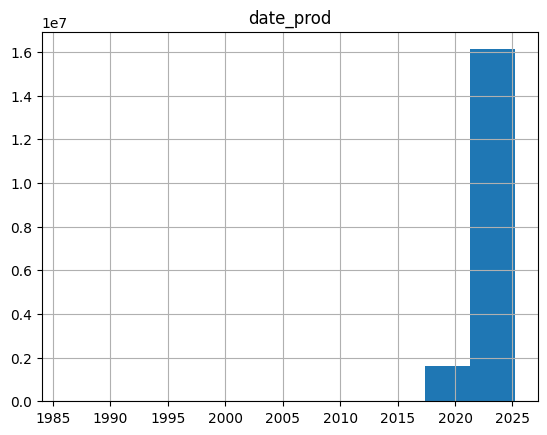

In [33]:
raw_datasets['well_production'][['date_prod']].hist();

Indeed, nearly all of the data is recent. It would be interesting to see how evenly distribution that data is on the massive left tail:

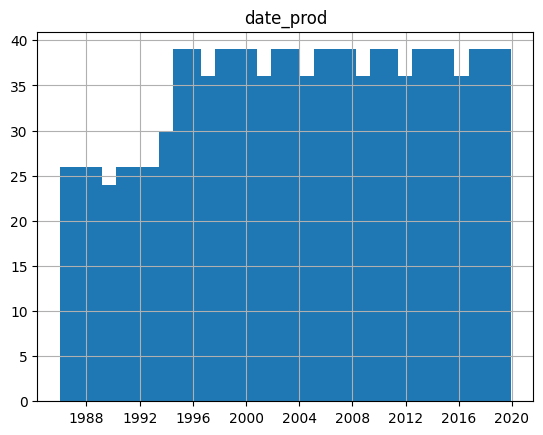

In [37]:
Pre2020 = raw_datasets['well_production'][raw_datasets['well_production']['date_prod'] < "2020-01-01"]
Pre2020[['date_prod']].hist(bins=32);

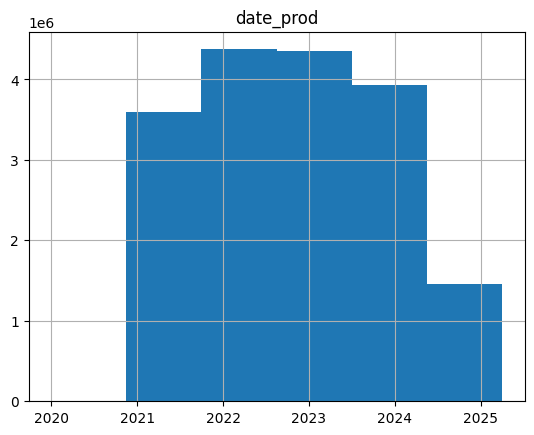

In [38]:
Post2020 = raw_datasets['well_production'][raw_datasets['well_production']['date_prod'] >= "2020-01-01"]
Post2020[['date_prod']].hist(bins=6);

So before 2020, we had something in the ballpark of 25 to 40 well production readings per year, and now it's climbed to millions per year, mainly in 2021 it seems since in 2020 there seems to have been somewhat of a decline due to covid

In [40]:
raw_datasets['well_production']['date_prod'].value_counts().value_counts()

count
3         329
2          96
393049      1
395589      1
395311      1
394995      1
394832      1
394461      1
394165      1
394030      1
393600      1
393462      1
392936      1
395783      1
392911      1
392654      1
392491      1
392114      1
391734      1
391445      1
156817      1
63563       1
63109       1
395619      1
400638      1
400500      1
396301      1
400486      1
400218      1
399954      1
399819      1
399492      1
399285      1
399135      1
398613      1
398514      1
398468      1
397910      1
397680      1
397407      1
397401      1
397240      1
397194      1
397071      1
396961      1
396784      1
396637      1
396502      1
396024      1
Name: count, dtype: int64

So nearly every datetime period has only 2 or 3 values (or wells) that it has data for, and then there is a huge spike, probably in 2021.

In [42]:
Pre2020['date_prod'].value_counts().value_counts()

count
3    312
2     96
Name: count, dtype: int64

In [45]:
Post2020['date_prod'].value_counts().tail(20)

date_prod
2024-09-01    156817
2024-11-01     63563
2024-10-01     63109
2020-10-01         3
2020-12-01         3
2025-02-01         3
2025-01-01         3
2025-03-01         3
2024-12-01         3
2020-06-01         3
2020-09-01         3
2020-05-01         3
2020-03-01         3
2020-01-01         3
2020-08-01         3
2020-11-01         3
2020-04-01         3
2020-07-01         3
2020-02-01         3
2025-04-01         3
Name: count, dtype: int64

All 12 months of 2020 are before the spike as well, and the last month of 2024 and the last 4 months of 2025 are back down to pre-spike levels (maybe it's just an artifact of data availability)

Almost ALL of our data is from the years 2021 through 2024

In [46]:
raw_datasets['well_production']['gas_monthly'].describe()

count    1.772208e+07
mean     2.567404e+03
std      2.131087e+04
min      0.000000e+00
25%      0.000000e+00
50%      3.800000e+01
75%      6.890000e+02
max      1.614492e+07
Name: gas_monthly, dtype: float64

In [13]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [48]:
raw_datasets['well_production']['gas_monthly'].describe()

count   17722083.00
mean        2567.40
std        21310.87
min            0.00
25%            0.00
50%           38.00
75%          689.00
max     16144920.00
Name: gas_monthly, dtype: float64

In [51]:
spike_period = raw_datasets['well_production'][(raw_datasets['well_production']['date_prod'] >= "2021-01-01") & (raw_datasets['well_production']['date_prod'] < "2024-12-01")]
spike_period['date_prod'].describe()

count                      17720904
mean     2022-10-25 01:15:43.008000
min             2021-01-01 00:00:00
25%             2021-12-01 00:00:00
50%             2022-11-01 00:00:00
75%             2023-10-01 00:00:00
max             2024-11-01 00:00:00
Name: date_prod, dtype: object

In [52]:
spike_period['gas_monthly'].describe()

count   17720904.00
mean        2481.80
std        18220.70
min            0.00
25%            0.00
50%           38.00
75%          689.00
max     16144920.00
Name: gas_monthly, dtype: float64

Even in the spike period, it turns out that lots of months have very low values or even no values for gas monthly production, maybe this is just a consequence of reporting though

In [53]:
spike_period['gas_monthly'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count   17720904.00
mean        2481.80
std        18220.70
min            0.00
10%            0.00
20%            0.00
30%            1.00
40%           10.00
50%           38.00
60%          126.00
70%          398.00
80%         1202.00
90%         4183.00
max     16144920.00
Name: gas_monthly, dtype: float64

And the max value is quite an anomoly even compared to the 90 percentile, which could mean it's the result of fracking practices which have high early productivity. I should investigate that by figuring out where that occurs and how many other anomolous values like that there are:

In [55]:
raw_datasets['well_production'].sort_values(by='gas_monthly', ascending=False).head(20)

,date_prod,api_no_10,gas_monthly,oil_monthly,production_month,start_date,county,sub_region,region
9855698,2023-04-01,4220335531,16144920.00,0.00,2,2023-03-01,HARRISON,Haynesville - TX,None
796330,2023-05-01,4220335531,14510120.00,0.00,3,2023-03-01,HARRISON,Haynesville - TX,None
13453280,2023-03-01,4220335531,12883440.00,0.00,1,2023-03-01,HARRISON,Haynesville - TX,None
17630797,2023-06-01,4220335531,12432120.00,0.00,4,2023-03-01,HARRISON,Haynesville - TX,None
16458519,2023-07-01,4220335531,11653520.00,0.00,5,2023-03-01,HARRISON,Haynesville - TX,None
5766779,2023-08-01,4220335531,10453240.00,0.00,6,2023-03-01,HARRISON,Haynesville - TX,None
7999771,2023-09-01,4220335531,9251360.00,0.00,7,2023-03-01,HARRISON,Haynesville - TX,None
3742723,2023-10-01,4220335531,8484760.00,0.00,8,2023-03-01,HARRISON,Haynesville - TX,None
9495095,2023-11-01,4220335531,7592120.00,0.00,9,2023-03-01,HARRISON,Haynesville - TX,None
3884731,2023-12-01,4220335531,7143800.00,0.00,10,2023-03-01,HARRISON,Haynesville - TX,None


The highest values are mostly from the same well, so it's not very anomalous, which is good, and we see a few other wells near that top spot as well

We also see that some wells produce both gas and oil, whereas a lot produce just gas, so it makes sense that a lot of values would be 0. We might later want to sanity check more of the zero values when cleaning though, such as checking the zero values belong to wells that typically have zero values since some of them might show up as anomalies instead of more natural zeroes, due to reporting lapses for example

In [56]:
raw_datasets['well_production']['oil_monthly'].describe()

count   17722083.00
mean         400.66
std         2248.04
min            0.00
25%            0.00
50%           18.00
75%           94.00
max      1391600.00
Name: oil_monthly, dtype: float64

In [57]:
spike_period['oil_monthly'].describe(percentiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count   17720904.00
mean         400.69
std         2248.12
min            0.00
10%            0.00
20%            0.00
30%            1.00
40%            7.00
50%           18.00
60%           37.00
70%           67.00
80%          138.00
90%          403.00
max      1391600.00
Name: oil_monthly, dtype: float64

The oil data shape looks very similar to the gas data shape, just with somewhat smaller values

In [58]:
raw_datasets['well_production'].sort_values(by='oil_monthly', ascending=False).head(20)

,date_prod,api_no_10,gas_monthly,oil_monthly,production_month,start_date,county,sub_region,region
12664980,2023-03-01,4229736275,5403200.00,1391600.00,1,2023-03-01,LIVE OAK,South - TX,None
741470,2023-04-01,4229736275,4261280.00,880160.00,2,2023-03-01,LIVE OAK,South - TX,None
614998,2022-10-01,4230135850,1422145.00,702988.00,3,2022-08-01,LOVING,West - TX,None
6953386,2023-05-01,4229736275,3766200.00,689240.00,3,2023-03-01,LIVE OAK,South - TX,None
8814153,2024-04-01,4247944838,0.00,540077.00,14,2023-03-01,WEBB,South - TX,None
16864707,2023-06-01,4229736275,3227640.00,511600.00,4,2023-03-01,LIVE OAK,South - TX,None
6681108,2021-10-01,4230135050,968375.00,472368.00,2,2021-09-01,LOVING,West - TX,None
14058231,2023-07-01,4229736275,3066720.00,444360.00,5,2023-03-01,LIVE OAK,South - TX,None
13214054,2022-07-01,4231743731,378890.00,424842.00,2,2022-06-01,MARTIN,West - TX,None
15591002,2024-04-01,4247944839,0.00,391266.00,14,2023-03-01,WEBB,South - TX,None


It's the same thing, often gas > oil, but there are some wells where there is oil but no gas.

Another thing that would be good to understand about gas and oil are the units that they are being reported in: I'm not sure how much it matters for forecasting in itself as long as it's consistent, but it would certainly matter when explaining it to someone.

I also notice that there are basically no genuine floating point values, the floats for oil and gas seem basically like integers.

By looking at these charts, it's also pretty easy to see what production_month and start_date refer to (and we can investigate this by pinpointing an API or two):
- production month refers to how many months the individual well has been in production by that point
- start date just refers to when the well started producing and had "month 1" (and we should investigate that start date never changes for individual wells), I'm not sure start date makes sense to include in the final forecasting model but we'll see

In [60]:
raw_datasets['well_production'][raw_datasets['well_production']['api_no_10'] == '4229736275'].sort_values(by='date_prod')

,date_prod,api_no_10,gas_monthly,oil_monthly,production_month,start_date,county,sub_region,region
12664980,2023-03-01,4229736275,5403200.00,1391600.00,1,2023-03-01,LIVE OAK,South - TX,None
741470,2023-04-01,4229736275,4261280.00,880160.00,2,2023-03-01,LIVE OAK,South - TX,None
6953386,2023-05-01,4229736275,3766200.00,689240.00,3,2023-03-01,LIVE OAK,South - TX,None
16864707,2023-06-01,4229736275,3227640.00,511600.00,4,2023-03-01,LIVE OAK,South - TX,None
14058231,2023-07-01,4229736275,3066720.00,444360.00,5,2023-03-01,LIVE OAK,South - TX,None
12233942,2023-08-01,4229736275,2404440.00,353960.00,6,2023-03-01,LIVE OAK,South - TX,None
12207965,2023-09-01,4229736275,1861760.00,272080.00,7,2023-03-01,LIVE OAK,South - TX,None
17350515,2023-10-01,4229736275,1574240.00,242600.00,8,2023-03-01,LIVE OAK,South - TX,None
5542754,2023-11-01,4229736275,1430360.00,238520.00,9,2023-03-01,LIVE OAK,South - TX,None
1016162,2023-12-01,4229736275,1269440.00,209960.00,10,2023-03-01,LIVE OAK,South - TX,None


In [61]:
raw_datasets['well_production'][raw_datasets['well_production']['api_no_10'] == '4220335531'].sort_values(by='date_prod')

,date_prod,api_no_10,gas_monthly,oil_monthly,production_month,start_date,county,sub_region,region
13453280,2023-03-01,4220335531,12883440.00,0.00,1,2023-03-01,HARRISON,Haynesville - TX,None
9855698,2023-04-01,4220335531,16144920.00,0.00,2,2023-03-01,HARRISON,Haynesville - TX,None
796330,2023-05-01,4220335531,14510120.00,0.00,3,2023-03-01,HARRISON,Haynesville - TX,None
17630797,2023-06-01,4220335531,12432120.00,0.00,4,2023-03-01,HARRISON,Haynesville - TX,None
16458519,2023-07-01,4220335531,11653520.00,0.00,5,2023-03-01,HARRISON,Haynesville - TX,None
5766779,2023-08-01,4220335531,10453240.00,0.00,6,2023-03-01,HARRISON,Haynesville - TX,None
7999771,2023-09-01,4220335531,9251360.00,0.00,7,2023-03-01,HARRISON,Haynesville - TX,None
3742723,2023-10-01,4220335531,8484760.00,0.00,8,2023-03-01,HARRISON,Haynesville - TX,None
9495095,2023-11-01,4220335531,7592120.00,0.00,9,2023-03-01,HARRISON,Haynesville - TX,None
3884731,2023-12-01,4220335531,7143800.00,0.00,10,2023-03-01,HARRISON,Haynesville - TX,None


So it seems I've interpreted production month and start date correctly, we'll just need to do more thorough validations of them later

There is also good news for start_date: since production_month has no missing values, we can use production_month "1" to impute any missing values of start_date if necessary

I just want to do a few more things to the production data:
- encode start_date as a datetime column
- describe production_month and start_date
- look at the distributions of county, sub_region and region

In [14]:
raw_datasets['well_production']['start_date'] = pd.to_datetime(raw_datasets['well_production']['start_date'])
raw_datasets['well_production'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 17722083 entries, 0 to 17724874
Data columns (total 9 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date_prod         datetime64[ms]
 1   api_no_10         object        
 2   gas_monthly       float64       
 3   oil_monthly       float64       
 4   production_month  int64         
 5   start_date        datetime64[ns]
 6   county            object        
 7   sub_region        object        
 8   region            object        
dtypes: datetime64[ms](1), datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.3+ GB


In [66]:
raw_datasets['well_production'][['production_month', 'start_date']].describe()

,production_month,start_date
count,17722083.00,17719431
mean,257.15,2001-04-13 23:59:27.993916288
min,0.00,1986-01-01 00:00:00
25%,146.00,1993-01-01 00:00:00
50%,326.00,1994-11-01 00:00:00
75%,356.00,2010-10-01 00:00:00
max,472.00,2025-02-01 00:00:00
std,116.17,NaN


So most of the wells have been active for a rather long time, like several hundreds months of production, and most of them aren't new, which makes me wonder how that's represented in the data, like newer wells (maybe due to the fracking revolution) must be far more productive than many of these more standard wells that have been active for a long time

It's also a bit odd to me in general that the 50 percentile is more than half of the max value, I'm not sure how it makes sense with a minimum start date of 1986, but we'll have to check for errors in production month as well by making sure it actually goes up by 1 every single time and starts at 1. One guess I'd have for why a distribution like this with such a high median value compared to the mean is a lot of wells did not report their data for many of the early months, so the early production months are missing for a lot of wells with earlier start dates that are consistent with the start date column (and since only later production months were reported, the median value for the parameter is inflated)

It does seem that most of the wells were started before the spike period so the reason for the spike isn't just founding a bunch of wells at that time (although the one's that were founded may have far better initial performance due to fracking)

In [67]:
raw_datasets['well_production']['county'].value_counts()

county
ANDREWS     659289
ECTOR       553244
WICHITA     439965
CROCKETT    395831
MIDLAND     382797
             ...  
SWISHER         42
PRESIDIO        24
BLANCO          22
FANNIN           3
KERR             1
Name: count, Length: 227, dtype: int64

This might be good information, but there's still the possibility that it has too many classes to be useful, dimensionality reduction of the class could be useful, we'll see though

In [68]:
raw_datasets['well_production']['sub_region'].value_counts()

sub_region
West - TX           7601145
Central - TX        3830071
South - TX          3789377
North - TX          1367894
Haynesville - TX    1133596
Name: count, dtype: int64

The sub regions are all regions of Texas, which is exactly what we wanted to see, though we will still need to verify lat and lon values from the geospatial perspective

In [69]:
raw_datasets['well_production']['region'].value_counts()

region
west    1320
Name: count, dtype: int64

This seems like useless information, we're just going to drop this column

In [15]:
raw_datasets['well_production'].drop('region', axis=1, inplace=True)
raw_datasets['well_production'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 17722083 entries, 0 to 17724874
Data columns (total 8 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date_prod         datetime64[ms]
 1   api_no_10         object        
 2   gas_monthly       float64       
 3   oil_monthly       float64       
 4   production_month  int64         
 5   start_date        datetime64[ns]
 6   county            object        
 7   sub_region        object        
dtypes: datetime64[ms](1), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.2+ GB


#### Well Properties <a id="Properties"></a>

Due to the number of missing values in the well properties, there will be much more focus here on co-occuring missing values

In [73]:
raw_datasets['well_properties']['operator_name'].value_counts().value_counts()

count
1      3097
2      1199
3       729
4       495
5       352
       ... 
502       1
506       1
508       1
515       1
268       1
Name: count, Length: 429, dtype: int64

Indeed many operators seem to have a very small number of wells, so having a large vs small operator may be a noteworthy feature

In [76]:
raw_datasets['well_properties']['operator_name'].value_counts().head(20)

operator_name
HILCORP ENERGY COMPANY              15764
OCCIDENTAL PERMIAN LTD.             10782
SCOUT ENERGY MANAGEMENT LLC         10105
DIAMONDBACK E&P LLC                  9702
PIONEER NATURAL RES. USA, INC.       9562
UPP OPERATING, LLC                   7286
EOG RESOURCES, INC.                  5616
APACHE CORPORATION                   4931
XTO ENERGY INC.                      4726
SABINAL ENERGY OPERATING, LLC        4658
BKV BARNETT, LLC                     4334
DIVERSIFIED PRODUCTION LLC           4205
BASA RESOURCES, INC.                 3617
JAVELIN ENERGY PARTNERS MGMT LLC     3501
COG OPERATING LLC                    3405
CONTANGO RESOURCES, LLC              3396
FORMENTERA OPERATIONS LLC            3083
OXY USA WTP LP                       3026
BURK ROYALTY CO., LTD.               2973
KINDER MORGAN PRODUCTION CO LLC      2819
Name: count, dtype: int64

In [77]:
raw_datasets['well_properties']['operator_name'].value_counts().describe()

count    9646.00
mean       44.65
std       341.59
min         1.00
25%         1.00
50%         3.00
75%        14.00
max     15764.00
Name: count, dtype: float64

In [82]:
def find_missing_cooccurrences(df, column_name):
  """
    Calculates how many missing values in the specified column
    co-occur with missing values in other columns.

    Args:
        df: The input pandas DataFrame.
        column_name: The name of the column to analyze.

    Returns:
       A dictionary where keys are other column names and values are the number of rows
       where the input column and the other column share missing values.
    """

  # Generate boolean mask for missing values in the input column
  missing_input_col = df[column_name].isnull()

  cooccurrence_counts = {}
  nonnull_cols=['lon_surface', 'lat_surface', 'lon_bottomhole', 'lat_bottomhole', 'depth_tvd', 'measured_depth', 'horizontal_length', 'wellbore_type', 'field_name', 'sub_region']
  for col in nonnull_cols:
    if col != column_name:
      missing_other_col = df[col].isnull()
        # Count the number of rows where both masks are True
      cooccurrence_counts[col] = (missing_input_col & missing_other_col).sum()
  return cooccurrence_counts

In [83]:
find_missing_cooccurrences(raw_datasets['well_properties'], 'operator_name')

{'lon_surface': 0,
 'lat_surface': 0,
 'lon_bottomhole': 3,
 'lat_bottomhole': 3,
 'depth_tvd': 1,
 'measured_depth': 3,
 'horizontal_length': 1,
 'wellbore_type': 3,
 'field_name': 4,
 'sub_region': 3}

There seems like some meaningful co-occurrence here, but it's such small numbers that it probably doesn't matter too much

In [84]:
raw_datasets['well_properties'][['lon_surface', 'lat_surface']].describe()

,lon_surface,lat_surface
count,428394.00,428394.00
mean,-99.82,31.81
std,2.57,2.00
min,-107.74,25.98
25%,-102.02,30.87
50%,-100.31,32.04
75%,-97.90,32.94
max,-93.53,36.50


There does seem to be some data there that may be slightly outside Texas (which has a western most point of -106.6), but it mostly looks sensible

In [85]:
find_missing_cooccurrences(raw_datasets['well_properties'], 'lon_surface')

{'lat_surface': 2267,
 'lon_bottomhole': 2267,
 'lat_bottomhole': 2267,
 'depth_tvd': 2234,
 'measured_depth': 826,
 'horizontal_length': 2248,
 'wellbore_type': 2187,
 'field_name': 1,
 'sub_region': 0}

In [86]:
find_missing_cooccurrences(raw_datasets['well_properties'], 'lat_surface')

{'lon_surface': 2267,
 'lon_bottomhole': 2267,
 'lat_bottomhole': 2267,
 'depth_tvd': 2234,
 'measured_depth': 826,
 'horizontal_length': 2248,
 'wellbore_type': 2187,
 'field_name': 1,
 'sub_region': 0}

We see perfect co-occurrence in the case of bottomhole lat/lon values, so if we're missing surface values we have no exact location information.

Depth_tvd, horizontal_length and wellbore_type also have very good co-occurrence, but I don't see much relationship here. Unfortunately in these cases we have very little information about the wells in question, so that seems to be the main thing indicated, and since we need to forecast decline for all wells, we will need to decide what to do about this.

One thing that comes to mind is using some kind of clustering solution and figuring out for these wells what production cluster they belong into, and use that to impute the other values as best as possible (including average lat/lon in the cluster or imputed region, etc.)

In [87]:
raw_datasets['well_properties'][['lon_bottomhole', 'lat_bottomhole']].describe()

,lon_bottomhole,lat_bottomhole
count,428382,428382
unique,414990,409858
top,-99.163214,31.999819
freq,8,6


These need to be floats, not strings

In [16]:
raw_datasets['well_properties']['lon_bottomhole'] = pd.to_numeric(raw_datasets['well_properties']['lon_bottomhole'])
raw_datasets['well_properties']['lat_bottomhole'] = pd.to_numeric(raw_datasets['well_properties']['lat_bottomhole'])
raw_datasets['well_properties'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430661 entries, 0 to 430660
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   api_no_10          430661 non-null  object 
 1   operator_name      430657 non-null  object 
 2   lon_surface        428394 non-null  float64
 3   lat_surface        428394 non-null  float64
 4   lon_bottomhole     428382 non-null  float64
 5   lat_bottomhole     428382 non-null  float64
 6   elevation_ground   0 non-null       object 
 7   depth_tvd          32733 non-null   float64
 8   lower_perf         0 non-null       object 
 9   upper_perf         0 non-null       object 
 10  measured_depth     391995 non-null  object 
 11  horizontal_length  102008 non-null  float64
 12  wellbore_type      428462 non-null  object 
 13  field_name         429374 non-null  object 
 14  township           0 non-null       object 
 15  section            0 non-null       object 
 16  ra

In [91]:
raw_datasets['well_properties'][['lon_bottomhole', 'lat_bottomhole']].describe()

,lon_bottomhole,lat_bottomhole
count,428382.00,428382.00
mean,-99.82,31.81
std,2.57,2.00
min,-104.84,25.97
25%,-102.02,30.87
50%,-100.31,32.03
75%,-97.90,32.94
max,-93.53,36.50


These values also look sane, so we'll move on

In [92]:
find_missing_cooccurrences(raw_datasets['well_properties'], 'lon_bottomhole')

{'lon_surface': 2267,
 'lat_surface': 2267,
 'lat_bottomhole': 2279,
 'depth_tvd': 2243,
 'measured_depth': 830,
 'horizontal_length': 2252,
 'wellbore_type': 2199,
 'field_name': 4,
 'sub_region': 3}

In [93]:
find_missing_cooccurrences(raw_datasets['well_properties'], 'lat_bottomhole')

{'lon_surface': 2267,
 'lat_surface': 2267,
 'lon_bottomhole': 2279,
 'depth_tvd': 2243,
 'measured_depth': 830,
 'horizontal_length': 2252,
 'wellbore_type': 2199,
 'field_name': 4,
 'sub_region': 3}

It's a very similar case to the surface lat/lon, perfect co-occurrence with the other bottomhole, surface has a very lacking on the bottom but it's roughly the same amount, and there is high co-occurrence with some other features which implies that certain wells simply have very little information

In [94]:
raw_datasets['well_properties']['depth_tvd'].describe()

count   32733.00
mean     7476.00
std      2808.32
min       100.00
25%      5250.00
50%      7861.00
75%      9480.00
max     21708.00
Name: depth_tvd, dtype: float64

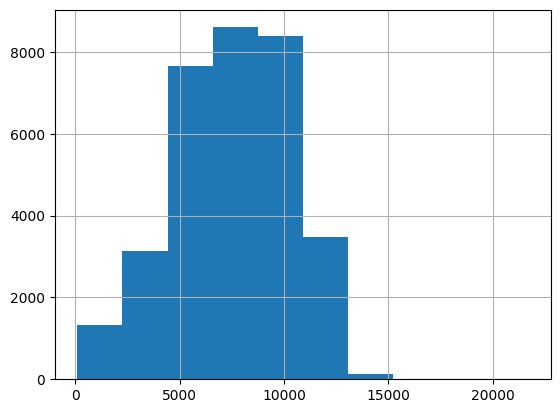

In [96]:
raw_datasets['well_properties']['depth_tvd'].hist();

The values seem to follow a reasonable enough curve that has a roughly bell shape without anything seeming outlandish, so I think we can move on here

In [97]:
find_missing_cooccurrences(raw_datasets['well_properties'], 'depth_tvd')

{'lon_surface': 2234,
 'lat_surface': 2234,
 'lon_bottomhole': 2243,
 'lat_bottomhole': 2243,
 'measured_depth': 38623,
 'horizontal_length': 314838,
 'wellbore_type': 2190,
 'field_name': 1282,
 'sub_region': 0}

The only highly co-occurring value is horizontal length, maybe it's the case that these tend to be measured together or only for certain types of wellbores. In the other cases, co-occurrence values are small enough that there might be hope to impute a value like this from those (such as from measured depth, although obviously it can't be the same, but maybe lon/lat at the surface and bottom can help us mathematically work out the difference)

In [98]:
raw_datasets['well_properties']['measured_depth'].describe()

count      391995
unique      16379
top       3200.00
freq          888
Name: measured_depth, dtype: object

Gotta convert this one to numeric as well

In [17]:
raw_datasets['well_properties']['measured_depth'] = pd.to_numeric(raw_datasets['well_properties']['measured_depth'])
raw_datasets['well_properties'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430661 entries, 0 to 430660
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   api_no_10          430661 non-null  object 
 1   operator_name      430657 non-null  object 
 2   lon_surface        428394 non-null  float64
 3   lat_surface        428394 non-null  float64
 4   lon_bottomhole     428382 non-null  float64
 5   lat_bottomhole     428382 non-null  float64
 6   elevation_ground   0 non-null       object 
 7   depth_tvd          32733 non-null   float64
 8   lower_perf         0 non-null       object 
 9   upper_perf         0 non-null       object 
 10  measured_depth     391995 non-null  float64
 11  horizontal_length  102008 non-null  float64
 12  wellbore_type      428462 non-null  object 
 13  field_name         429374 non-null  object 
 14  township           0 non-null       object 
 15  section            0 non-null       object 
 16  ra

In [100]:
raw_datasets['well_properties']['measured_depth'].describe()

count   391995.00
mean      6746.12
std       3553.44
min          1.00
25%       3735.50
50%       6796.00
75%       9500.00
max      26805.00
Name: measured_depth, dtype: float64

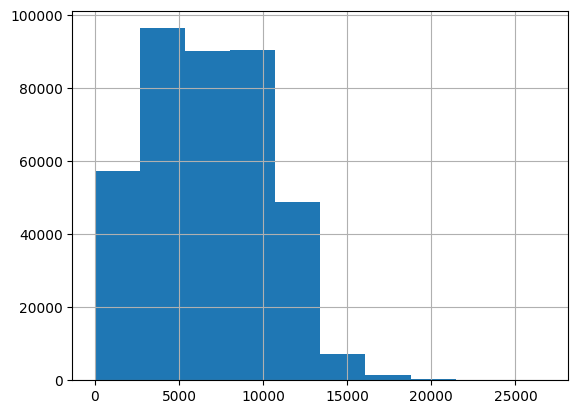

In [101]:
raw_datasets['well_properties']['measured_depth'].hist();

Not a bell curve, but nonetheless it's a pretty continuous, smooth looking distribution that seems plausible enough not to need a major overhaul

In [102]:
find_missing_cooccurrences(raw_datasets['well_properties'], 'measured_depth')

{'lon_surface': 826,
 'lat_surface': 826,
 'lon_bottomhole': 830,
 'lat_bottomhole': 830,
 'depth_tvd': 38623,
 'horizontal_length': 37972,
 'wellbore_type': 825,
 'field_name': 515,
 'sub_region': 3}

Near perfect co-occurrence in the case of depth_tvd and horizontal_length, so these seem like strongly related features which is how it already seemed in the case of investigating depth_tvd

In [103]:
raw_datasets['well_properties']['horizontal_length'].describe()

count   102008.00
mean      5772.75
std       3641.16
min          0.06
25%       3050.63
50%       5298.67
75%       8290.70
max      22742.08
Name: horizontal_length, dtype: float64

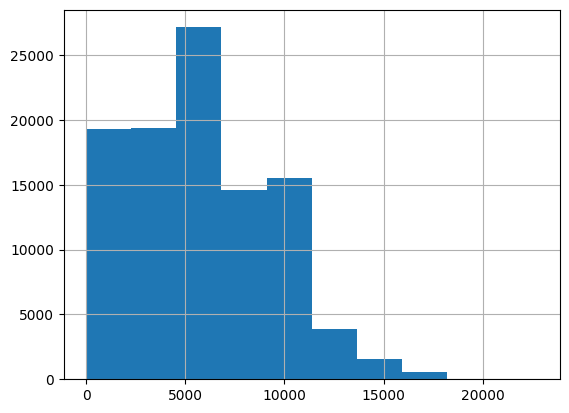

In [104]:
raw_datasets['well_properties']['horizontal_length'].hist();

There are some spikes in this graph, but that doesn't necessarily seem unreasonable, there don't seem to be huge outliers either so let's run with it

In [105]:
find_missing_cooccurrences(raw_datasets['well_properties'], 'horizontal_length')

{'lon_surface': 2248,
 'lat_surface': 2248,
 'lon_bottomhole': 2252,
 'lat_bottomhole': 2252,
 'depth_tvd': 314838,
 'measured_depth': 37972,
 'wellbore_type': 2191,
 'field_name': 1226,
 'sub_region': 0}

This has near perfect co-occurrence for every single feature, so horizontal_length is useful predictor of missing data and data quality in general (but not that good since it's missing much more than most of the other columns, and sometimes that may be for good reason like not being related to the type of wellbore)

In [106]:
raw_datasets['well_properties']['wellbore_type'].value_counts()

wellbore_type
Unknown        326435
Horizontal      89083
Directional     12944
Name: count, dtype: int64

This is unfortunate, since although there weren't many missing values on the face of it, in fact like 75% of the data just says "unknown" and is therefore missing. So it might have to be imputed from the production profile, but in turn that could give a lot of information

In [107]:
find_missing_cooccurrences(raw_datasets['well_properties'], 'wellbore_type')

{'lon_surface': 2187,
 'lat_surface': 2187,
 'lon_bottomhole': 2199,
 'lat_bottomhole': 2199,
 'depth_tvd': 2190,
 'measured_depth': 825,
 'horizontal_length': 2191,
 'field_name': 4,
 'sub_region': 3}

near perfect co-occurrence with everything except measured depth and field name

I would also be interesting in asking the question of what missing values correspond to the 'unknown' class. It would easily be possible to generalize the function I created to deal with different values besides null, but we'll just make a different version below for simplicity's sake

In [114]:
def find_unknown_cooccurrences(df, column_name):
  """
    Calculates how many unknown values in the specified column
    co-occur with missing values in other columns.

    Args:
        df: The input pandas DataFrame.
        column_name: The name of the column to analyze.

    Returns:
       A dictionary where keys are other column names and values are the number of rows
       where the input column and the other column share unknown and missing values.
    """

  # Generate boolean mask for missing values in the input column
  unknown_input_col = df[column_name]=='Unknown'

  cooccurrence_counts = {}
  nonnull_cols=['lon_surface', 'lat_surface', 'lon_bottomhole', 'lat_bottomhole', 'depth_tvd', 'measured_depth', 'horizontal_length', 'wellbore_type', 'field_name', 'sub_region']
  for col in nonnull_cols:
    if col != column_name:
      missing_other_col = df[col].isnull()
        # Count the number of rows where both masks are True
      cooccurrence_counts[col] = (unknown_input_col & missing_other_col).sum()
  return cooccurrence_counts

In [115]:
find_unknown_cooccurrences(raw_datasets['well_properties'], 'wellbore_type')

{'lon_surface': 56,
 'lat_surface': 56,
 'lon_bottomhole': 56,
 'lat_bottomhole': 56,
 'depth_tvd': 312633,
 'measured_depth': 37149,
 'horizontal_length': 326431,
 'field_name': 1224,
 'sub_region': 0}

Near perfect co-occurrence with depth_tvd, measured_depth and horizontal_length. It's obvious why it would be the case for horizontal length, but maybe non-directional or non-horizontal drilling has an important relationship with depth as well.

Also near perfect co-occurrence with field_name

In [116]:
raw_datasets['well_properties']['field_name'].value_counts()

field_name
SPRABERRY (TREND AREA)              41438
NEWARK, EAST (BARNETT SHALE)        18322
WICHITA COUNTY REGULAR               8163
PHANTOM (WOLFCAMP)                   7232
EAGLEVILLE (EAGLE FORD-1)            7101
                                    ...  
NORTHERN RANCH, S. (GRETA SEG B)        1
NOBILE (CONGL. 6470)                    1
SMILEY, SE (AUSTIN CHALK)               1
GRETA, NORTH (6500 SD.)                 1
MONTE CHRISTO, SOUTH (11,130)           1
Name: count, Length: 19895, dtype: int64

In [118]:
raw_datasets['well_properties']['field_name'].value_counts().describe()

count   19895.00
mean       21.58
std       362.01
min         1.00
25%         1.00
50%         2.00
75%         5.00
max     41438.00
Name: count, dtype: float64

In [119]:
raw_datasets['well_properties']['field_name'].value_counts().head(30)

field_name
SPRABERRY (TREND AREA)              41438
NEWARK, EAST (BARNETT SHALE)        18322
WICHITA COUNTY REGULAR               8163
PHANTOM (WOLFCAMP)                   7232
EAGLEVILLE (EAGLE FORD-1)            7101
BRISCOE RANCH (EAGLEFORD)            5641
SAWYER (CANYON)                      5085
PANHANDLE HUTCHINSON COUNTY FLD.     4651
EAGLEVILLE (EAGLE FORD-2)            4611
LEVELLAND                            4125
PANHANDLE GRAY COUNTY FIELD          3986
FUHRMAN-MASCHO                       3867
WASSON                               3852
ARCHER COUNTY REGULAR                3693
SLAUGHTER                            3331
PANHANDLE, WEST                      3033
CARTHAGE (COTTON VALLEY)             2995
YOUNG COUNTY REGULAR                 2850
GOLDSMITH (CLEAR FORK)               2611
MCELROY                              2418
GIDDINGS (AUSTIN CHALK-3)            2380
WARD-ESTES, NORTH                    2303
MONTAGUE COUNTY REGULAR              2194
CARTHAGE (HAYNESVILLE S

It seems nearly all field_names have very low values, and this categorical feature also likely has too many classes to be useful, so we may need to summarize information about field_name with a field size to get a sense of the propitiousness of the zone and the crowding.

It could also be the case that differently labeled fields are actually the same field with slightly different labels, so we could run an nlp similarity search through this to make sure we don't miss that information

In [120]:
find_missing_cooccurrences(raw_datasets['well_properties'], 'field_name')

{'lon_surface': 1,
 'lat_surface': 1,
 'lon_bottomhole': 4,
 'lat_bottomhole': 4,
 'depth_tvd': 1282,
 'measured_depth': 515,
 'horizontal_length': 1226,
 'wellbore_type': 4,
 'sub_region': 3}

Near perfect co-occurrence with depth_tvd and horizontal_length

In [121]:
raw_datasets['well_properties']['county_name'].value_counts()

county_name
ANDREWS      15625
ECTOR        13035
MIDLAND      10829
MARTIN       10368
WICHITA      10234
             ...  
BLANCO           1
FANNIN           1
KERR             1
DALLAM           1
ARMSTRONG        1
Name: count, Length: 227, dtype: int64

This seems like a repeat of the county feature already in the production data, so we could maybe consider running some nlp similarity searches here as well and just making sure the features in these separate dataframes correspond. We may not take that much time on it if it turns out to possibly not be that useful for forecasting though, since some of these location features seem to cover similar information, so we only need to include so many of them, county's might also not have very precise locations due to irregular shapes in some cases

In [122]:
raw_datasets['well_properties']['sub_region'].value_counts()

sub_region
West - TX           188848
South - TX           92316
Central - TX         91125
North - TX           31683
Haynesville - TX     26686
Name: count, dtype: int64

This seems to be the exact same feature in both datasets, so we should just make sure it makes with production as well

Now we are moving onto the last, smallest dataframe, the formations:

#### Well Formations <a id="Formations"></a>

In [123]:
raw_datasets['well_formations']['formation'].value_counts()

formation
Barnett                162902
Wolfcamp A             116817
Eagle Ford              64557
Delaware                29416
Lower Eagle Ford         3753
Abo-yeso                 1692
Upper Eagle Ford          996
Wolfcamp                  879
Wolfcamp D                187
Third Bone Spring         142
Wolfcamp C                141
Wolfcamp A Upper          123
Second Bone Spring        108
Upper Barnett              98
Wolfcamp A Lower           64
Cherry Canyon              44
Lower Brushy Canyon        44
Tuscaloosa                 32
Upper Brushy Canyon        29
Wolfcamp B Lower           27
Wolfcamp B Upper           24
Bell Canyon                21
First Bone Spring          16
Bone Spring                10
Lower Barnett              10
Name: count, dtype: int64

To me this comes across as basically location information, kind of similar to county/field name, etc., but perhaps more specific in this case to the geological location

There is a question as to whether to keep it like this or to collapse it more (e.g. we have Wolfcamp, and Wolfcamp C, and Wolfcamp A Upper, etc.), so if we don't collapse this than some wells will have more specific information than others. That can be flagged as an aspect of data quality, but I'm not sure it's necessary at all since we also may be including geospatial information that will help pinpoint where exactly in the location the well is located, thus a larger categorical label may not be adding much.

It does give us something interesting to explore though, with things like groupby

In [124]:
raw_datasets['well_formations']['basin'].value_counts()

basin
Ft. Worth        163010
Permian          149784
Western Gulf      69306
TX-LA-MS Salt        32
Name: count, dtype: int64

Basin also seems to give us location information of a sort. Since it's geologically based, rather than being based on relatively arbitrary human boundaries like counties and field names seem to be, it might be more useful as a feature and save us the trouble of working with county data for this time limited assessment. **Here is a primer on the meanings of basin and formation and how they may be helpful to us, from AI**:

"In the context of your Texas well data and oil & gas production forecasting, "formation" and "basin" are crucial geological terms, representing different scales of analysis:

Basin:
A basin is a large-scale depression in the Earth's crust that accumulates layers of sediment over geological time.
Basins can be enormous, covering vast geographical areas.
They are essentially the "birthplace" of oil and gas, where organic matter is deposited and, over millions of years, transformed into hydrocarbons under intense heat and pressure.
Basins often contain multiple geological plays and several different types of traps that hold hydrocarbon reservoirs.
Examples from your data: Ft. Worth, Permian, Western Gulf, TX-LA-MS Salt. 

Formation:
A formation is a smaller, more specific layer of rock within a basin that is distinctive and continuous enough to be mapped.
Formations are the specific geological units where the oil or gas is contained.
In some cases, the source rock (where the hydrocarbons were formed) is also the reservoir rock (where they are stored), particularly in unconventional plays like shales.
Examples from your data: Barnett, Wolfcamp A, Eagle Ford, Delaware. 

In essence: A basin is the large-scale geographical and geological setting, while a formation is a particular rock layer within that basin that is targeted for drilling and production. 

Value of Knowing Formation and Basin for Forecasting:
Knowing the formation and basin is highly valuable for building forecasting models for well decline and state production totals:

Well Decline Forecasting:
Formation characteristics influence decline rates: Different formations have varying geological properties (like porosity, permeability, formation pressure) that directly affect how quickly production from a well will decline over time.
Completion methods are formation-dependent: Unconventional plays often require hydraulic fracturing (fracking) to extract oil and gas, and the effectiveness of these techniques can vary based on the specific formation's characteristics.
Specific decline curve analysis models may be better suited for different formations. For instance, the Bakken shale formation responds well to a decline curve model that accounts for an initial rapid decline followed by a more stable production period.

State Production Totals Forecasting:
Basin analysis provides a broader context: Understanding the overall hydrocarbon potential and geological history of a basin (like the Permian or Eagle Ford) is crucial for forecasting production trends across a larger region, like a state.
Analyzing rig trends and DUCs (drilled but uncompleted wells) within specific basins helps inform production forecasts. For example, tracking rig counts in the Permian or Eagle Ford provides insights into future drilling activity and potential production levels.
Identifying key formations within a basin with significant potential, like the Delaware Basin within the Permian, helps focus forecasting efforts and resource allocation.
Models based on basin-specific data and characteristics can lead to more accurate state-level production forecasts. 
In short, "formation" gives you insights into the specific reservoir rock being targeted, which is vital for understanding individual well performance. "Basin" provides the broader geological framework, essential for regional production forecasting and risk assessment. Analyzing both together creates a powerful framework for accurate and informed predictions in oil and gas production. "

**This also seems to support my thought that well forecasting would be better served by geological data as compared to county and field names**:

"Both geological data (basin, formation) and administrative/geographic data (county, field name) are valuable for building forecasting and production models, but they serve different purposes and offer different levels of granularity and insight. 

Geological Data (Basin, Formation): More Fundamental for Well Decline Forecasting
Formation-Level Details: Data about formations (like porosity, permeability, thickness) are fundamental to understanding the specific reservoir characteristics that drive individual well performance.
Influence on Decline Rates: The geological properties of a formation directly influence how quickly a well's production declines over time, a critical factor for decline curve analysis and reserve estimation.
Completion Optimization: Formations dictate optimal completion strategies (like fracking design) which, in turn, impact production and decline.
Basin-Level Context: Basin data provides a broader geological framework that helps understand regional hydrocarbon potential and informs overall development strategies. 

Administrative/Geographic Data (County, Field Name): Useful for Aggregation and Regulatory Compliance
County-Level Aggregation: County-level data is essential for aggregating well-level data to understand regional production trends and to comply with state-level reporting and regulatory requirements.
Field-Level Performance: Field data allows for analysis of performance within specific administrative field boundaries, aiding in reservoir management and optimization within a defined area.
Resource Allocation: Field and county data can be used to assess resource allocation and infrastructure planning within a particular area. 

Comparison:
Granularity: Formation data offers the highest level of detail for understanding individual well performance and decline. County data, on the other hand, provides a broader overview of production across a larger geographic region.
Predictive Power: Geological data is more directly tied to the fundamental physical processes driving hydrocarbon extraction, making it highly valuable for predicting individual well decline and overall formation productivity.
Practical Applications: County data is valuable for administrative purposes, regulatory compliance, and understanding regional production trends. Field data aids in managing production within specific fields. 

Which is more useful?
Both geological and administrative data are important, but their relative usefulness depends on the specific forecasting or production modeling goal:
For models focused on individual well decline forecasting and optimization, formation-level data is likely to be more useful, as it directly impacts reservoir behavior and production decline curves.
For models aimed at state-level production forecasting and broader resource assessment, both basin and formation data are essential for understanding regional potential and trends. County-level data, while useful for aggregation and regional reporting, might not provide the same level of predictive power as the underlying geological information. 

In conclusion: Geological data (basin, formation) is crucial for understanding the underlying physical processes driving production, especially for individual well decline analysis. Administrative data (county, field) is valuable for aggregating data, regulatory compliance, and understanding regional trends. A comprehensive modeling approach would ideally incorporate both types of data to gain a complete understanding of production dynamics at both the well and regional levels."

In [125]:
comprehensive_data_overview(raw_datasets)


DATASET: WELL_PRODUCTION
Shape: (17722083, 8)

Column Overview:
Column                    Type            Non-Null   Unique     Missing % 
--------------------------------------------------------------------------------
date_prod                 datetime64[ms]  17722083   472        0.0       %
api_no_10                 object          17722083   430661     0.0       %
gas_monthly               float64         17722083   130811     0.0       %
oil_monthly               float64         17722083   38712      0.0       %
production_month          int64           17722083   473        0.0       %
start_date                datetime64[ns]  17719431   387        0.0       %
county                    object          17722083   227        0.0       %
sub_region                object          17722083   5          0.0       %

Potential date/time columns: ['date_prod', 'gas_monthly', 'oil_monthly', 'production_month', 'start_date']

Production columns: ['date_prod', 'gas_monthly', 'oil_monthly'

## Data Quality Assessment and Cleaning <a id="Clean"></a>

### Understanding Production Units and Data Context <a id="Units"></a>

In [129]:
def analyze_production_units(well_production_df):
    """
    Analyze production values to determine likely units based on Texas reporting standards
    and industry practices.
    """
    print("=== PRODUCTION UNITS ANALYSIS ===")
    
    # Based on research: Texas RRC reports oil in barrels (BBL) and gas in thousand cubic feet (MCF)
    print("Based on Texas Railroad Commission reporting standards:")
    print("- Oil production units: Barrels (BBL) - 42 US gallons per barrel")
    print("- Gas production units: Thousand Cubic Feet (MCF)")
    print("- Conversion factor: 6 MCF gas ≈ 1 BBL oil equivalent (BOE)")
    
    # Analyze the data ranges to confirm
    oil_stats = well_production_df['oil_monthly'].describe()
    gas_stats = well_production_df['gas_monthly'].describe()
    
    print(f"\nOil Production Statistics (assumed BBL):")
    print(f"  Mean: {oil_stats['mean']:,.0f} BBL/month")
    print(f"  Median: {oil_stats['50%']:,.0f} BBL/month") 
    print(f"  Maximum: {oil_stats['max']:,.0f} BBL/month")
    print(f"  Daily equivalent (max): {oil_stats['max']/30:.0f} BBL/day")
    
    print(f"\nGas Production Statistics (assumed MCF):")
    print(f"  Mean: {gas_stats['mean']:,.0f} MCF/month")
    print(f"  Median: {gas_stats['50%']:,.0f} MCF/month")
    print(f"  Maximum: {gas_stats['max']:,.0f} MCF/month") 
    print(f"  Daily equivalent (max): {gas_stats['max']/30:.0f} MCF/day")
    
    # Validation against industry benchmarks
    print(f"\nIndustry Validation:")
    print(f"- Typical unconventional well oil production: 100-2,000 BBL/day initially")
    print(f"- Typical unconventional well gas production: 1,000-50,000 MCF/day initially")
    print(f"- Your max oil daily: {oil_stats['max']/30:.0f} BBL/day (within reasonable range?)")
    print(f"- Your max gas daily: {gas_stats['max']/30:.0f} MCF/day (within reasonable range?)")
    
    return {
        'oil_units': 'BBL (Barrels)',
        'gas_units': 'MCF (Thousand Cubic Feet)',
        'oil_stats': oil_stats,
        'gas_stats': gas_stats
    }

In [130]:
units_analysis = analyze_production_units(raw_datasets['well_production'])
units_analysis

=== PRODUCTION UNITS ANALYSIS ===
Based on Texas Railroad Commission reporting standards:
- Oil production units: Barrels (BBL) - 42 US gallons per barrel
- Gas production units: Thousand Cubic Feet (MCF)
- Conversion factor: 6 MCF gas ≈ 1 BBL oil equivalent (BOE)

Oil Production Statistics (assumed BBL):
  Mean: 401 BBL/month
  Median: 18 BBL/month
  Maximum: 1,391,600 BBL/month
  Daily equivalent (max): 46387 BBL/day

Gas Production Statistics (assumed MCF):
  Mean: 2,567 MCF/month
  Median: 38 MCF/month
  Maximum: 16,144,920 MCF/month
  Daily equivalent (max): 538164 MCF/day

Industry Validation:
- Typical unconventional well oil production: 100-2,000 BBL/day initially
- Typical unconventional well gas production: 1,000-50,000 MCF/day initially
- Your max oil daily: 46387 BBL/day (within reasonable range?)
- Your max gas daily: 538164 MCF/day (within reasonable range?)


{'oil_units': 'BBL (Barrels)',
 'gas_units': 'MCF (Thousand Cubic Feet)',
 'oil_stats': count   17722083.00
 mean         400.66
 std         2248.04
 min            0.00
 25%            0.00
 50%           18.00
 75%           94.00
 max      1391600.00
 Name: oil_monthly, dtype: float64,
 'gas_stats': count   17722083.00
 mean        2567.40
 std        21310.87
 min            0.00
 25%            0.00
 50%           38.00
 75%          689.00
 max     16144920.00
 Name: gas_monthly, dtype: float64}

The max values are NOT necessarily reasonable in terms of their range, they are very very high, but it's hard to say whether they are from a google search whether these units or the values are reasonable. I'm going to come back to this with another function that will separate the different types of wells and calculate reasonable ranges for the data and units based on that. For now let's move on.

### Time Series Analysis and Spike Period Assessment <a id="Spike"></a>

In [133]:
def analyze_time_series_distribution(well_production_df):
    """
    Analyze the temporal distribution of production data to understand
    the spike period and its implications for forecasting.
    """
    print("=== TIME SERIES DISTRIBUTION ANALYSIS ===")
    
    df = well_production_df.copy()
    
    # Analyze reporting patterns by year
    df['year'] = df['date_prod'].dt.year
    yearly_counts = df['year'].value_counts().sort_index()
    
    print("Production Reports by Year:")
    for year, count in yearly_counts.items():
        print(f"  {year}: {count:,} reports")
    
    # Identify the spike period
    spike_threshold = 100  # Spike years, based on our previous visualization
    spike_years = yearly_counts[yearly_counts > spike_threshold].index.tolist()
    
    print(f"\nSpike Period Identification:")
    print(f"  Spike threshold: {spike_threshold:,.0f} reports/year")
    print(f"  Spike years: {min(spike_years)} to {max(spike_years)}")
    print(f"  Total spike period reports: {yearly_counts[spike_years].sum():,}")
    print(f"  Percentage of total data: {(yearly_counts[spike_years].sum() / len(df)) * 100:.1f}%")
    
    # Analyze well count by period
    pre_spike = df[df['year'] < min(spike_years)]
    spike_period = df[df['year'].isin(spike_years)]
    post_spike = df[df['year'] > max(spike_years)]
    
    print(f"\nWell Activity Analysis:")
    print(f"  Pre-spike unique wells: {pre_spike['api_no_10'].nunique():,}")
    print(f"  Spike period unique wells: {spike_period['api_no_10'].nunique():,}")
    print(f"  Post-spike unique wells: {post_spike['api_no_10'].nunique():,}")
    
    # Assessment for forecasting implications
    print(f"\nForecasting Implications:")
    print("The spike period (2021-2024) represents the modern unconventional boom period.")
    print("This is BENEFICIAL for forecasting because:")
    print("- Contains the most relevant recent production data")
    print("- Represents current drilling and completion technologies")
    print("- Includes wells with complete decline curves")
    print("- Reflects modern reporting practices")
    
    return {
        'spike_years': spike_years,
        'yearly_counts': yearly_counts,
        'spike_period_percentage': (yearly_counts[spike_years].sum() / len(df)) * 100,
        'recommendation': 'use_spike_period_focus'
    }

In [134]:
time_analysis = analyze_time_series_distribution(raw_datasets['well_production'])
time_analysis

=== TIME SERIES DISTRIBUTION ANALYSIS ===
Production Reports by Year:
  1986: 24 reports
  1987: 24 reports
  1988: 24 reports
  1989: 24 reports
  1990: 24 reports
  1991: 24 reports
  1992: 24 reports
  1993: 24 reports
  1994: 36 reports
  1995: 36 reports
  1996: 36 reports
  1997: 36 reports
  1998: 36 reports
  1999: 36 reports
  2000: 36 reports
  2001: 36 reports
  2002: 36 reports
  2003: 36 reports
  2004: 36 reports
  2005: 36 reports
  2006: 36 reports
  2007: 36 reports
  2008: 36 reports
  2009: 36 reports
  2010: 36 reports
  2011: 36 reports
  2012: 36 reports
  2013: 36 reports
  2014: 36 reports
  2015: 36 reports
  2016: 36 reports
  2017: 36 reports
  2018: 36 reports
  2019: 36 reports
  2020: 36 reports
  2021: 4,795,122 reports
  2022: 4,765,088 reports
  2023: 4,737,871 reports
  2024: 3,422,826 reports
  2025: 12 reports

Spike Period Identification:
  Spike threshold: 100 reports/year
  Spike years: 2021 to 2024
  Total spike period reports: 17,720,907
  Perce

{'spike_years': [2021, 2022, 2023, 2024],
 'yearly_counts': year
 1986         24
 1987         24
 1988         24
 1989         24
 1990         24
 1991         24
 1992         24
 1993         24
 1994         36
 1995         36
 1996         36
 1997         36
 1998         36
 1999         36
 2000         36
 2001         36
 2002         36
 2003         36
 2004         36
 2005         36
 2006         36
 2007         36
 2008         36
 2009         36
 2010         36
 2011         36
 2012         36
 2013         36
 2014         36
 2015         36
 2016         36
 2017         36
 2018         36
 2019         36
 2020         36
 2021    4795122
 2022    4765088
 2023    4737871
 2024    3422826
 2025         12
 Name: count, dtype: int64,
 'spike_period_percentage': 99.99336421119345,
 'recommendation': 'use_spike_period_focus'}

### Production Patterns and Zero Values <a id="ProdPatterns"></a>

In [135]:
def analyze_production_patterns(well_production_df):
    """
    Analyze production patterns to distinguish between true zero production
    and reporting gaps, and identify decline curve characteristics.
    """
    print("=== PRODUCTION PATTERNS ANALYSIS ===")
    
    df = well_production_df.copy()
    
    # Analyze zero values patterns
    oil_zeros = (df['oil_monthly'] == 0).sum()
    gas_zeros = (df['gas_monthly'] == 0).sum()
    both_zeros = ((df['oil_monthly'] == 0) & (df['gas_monthly'] == 0)).sum()
    
    print(f"Zero Production Analysis:")
    print(f"  Oil-only zeros: {oil_zeros:,} ({oil_zeros/len(df)*100:.1f}%)")
    print(f"  Gas-only zeros: {gas_zeros:,} ({gas_zeros/len(df)*100:.1f}%)")
    print(f"  Both oil and gas zeros: {both_zeros:,} ({both_zeros/len(df)*100:.1f}%)")
    
    # Analyze well types by production patterns
    well_production_summary = df.groupby('api_no_10').agg({
        'oil_monthly': ['sum', 'count', lambda x: (x == 0).sum()],
        'gas_monthly': ['sum', 'count', lambda x: (x == 0).sum()]
    }).round(2)
    
    well_production_summary.columns = ['oil_total', 'oil_months', 'oil_zeros', 
                                      'gas_total', 'gas_months', 'gas_zeros']
    
    # Classify wells by production type
    well_production_summary['oil_zero_pct'] = (well_production_summary['oil_zeros'] / 
                                              well_production_summary['oil_months'] * 100)
    well_production_summary['gas_zero_pct'] = (well_production_summary['gas_zeros'] / 
                                              well_production_summary['gas_months'] * 100)
    
    # Well type classification
    oil_only_wells = well_production_summary[
        (well_production_summary['oil_zero_pct'] < 20) & 
        (well_production_summary['gas_zero_pct'] > 80)
    ]
    
    gas_only_wells = well_production_summary[
        (well_production_summary['oil_zero_pct'] > 80) & 
        (well_production_summary['gas_zero_pct'] < 20)
    ]
    
    mixed_wells = well_production_summary[
        (well_production_summary['oil_zero_pct'] < 80) & 
        (well_production_summary['gas_zero_pct'] < 80)
    ]
    
    print(f"\nWell Type Classification:")
    print(f"  Oil-dominant wells: {len(oil_only_wells):,}")
    print(f"  Gas-dominant wells: {len(gas_only_wells):,}")
    print(f"  Mixed production wells: {len(mixed_wells):,}")
    print(f"  Total classified wells: {len(well_production_summary):,}")
    
    return {
        'zero_analysis': {
            'oil_zeros': oil_zeros,
            'gas_zeros': gas_zeros,
            'both_zeros': both_zeros
        },
        'well_types': {
            'oil_dominant': len(oil_only_wells),
            'gas_dominant': len(gas_only_wells),
            'mixed': len(mixed_wells)
        },
        'well_summary': well_production_summary
    }

In [136]:
production_patterns = analyze_production_patterns(raw_datasets['well_production'])

=== PRODUCTION PATTERNS ANALYSIS ===
Zero Production Analysis:
  Oil-only zeros: 4,894,427 (27.6%)
  Gas-only zeros: 5,247,398 (29.6%)
  Both oil and gas zeros: 2,270,747 (12.8%)

Well Type Classification:
  Oil-dominant wells: 49,183
  Gas-dominant wells: 46,750
  Mixed production wells: 270,805
  Total classified wells: 430,661


It would be good to design classification feature based on this, with a well being designated as oil dominant, gas dominant, mixed or possibly none of the above, but it might be best to use k-means clustering on oil/gas zero percents like that once everything has been imputed, trying to look for a value of 3 or 4 clusters or something like that as being likely.

It would be good to have a function that identifies api's that have entirely zeroes, because these are cases where we have no data and thus forecasting becomes a very difficult task (and as the pdf warned, it's likely that such cases aren't wells at all, a well should actually produce something at least once). I should then remove such api's from all 3 of the datasets.

In [18]:
def remove_all_zero_apis(well_production_df, well_properties_df, well_formations_df):
    """
    Remove APIs that have only zero values for both oil and gas production
    from all three datasets.
    Returns cleaned DataFrames and the list of excluded APIs.
    """
    # Step 1: Identify APIs with all-zero oil and gas production
    grouped = well_production_df.groupby('api_no_10').agg({
        'oil_monthly': 'sum',
        'gas_monthly': 'sum'
    })
    all_zero_apis = grouped[
        (grouped['oil_monthly'] == 0) & (grouped['gas_monthly'] == 0)
    ].index.tolist()

    print(f"APIs with only zero production: {len(all_zero_apis):,}")

    # Step 2: Remove these APIs from all datasets
    cleaned_well_production = well_production_df[
        ~well_production_df['api_no_10'].isin(all_zero_apis)
    ].copy()
    cleaned_well_properties = well_properties_df[
        ~well_properties_df['api_no_10'].isin(all_zero_apis)
    ].copy()
    cleaned_well_formations = well_formations_df[
        ~well_formations_df['api_no_10'].isin(all_zero_apis)
    ].copy()

    print(f"Rows removed from well_production: {well_production_df.shape[0] - cleaned_well_production.shape[0]:,}")
    print(f"Rows removed from well_properties: {well_properties_df.shape[0] - cleaned_well_properties.shape[0]:,}")
    print(f"Rows removed from well_formations: {well_formations_df.shape[0] - cleaned_well_formations.shape[0]:,}")

    return cleaned_well_production, cleaned_well_properties, cleaned_well_formations, all_zero_apis

In [19]:
wrangle_datasets = {}

wrangle_datasets['well_production'], wrangle_datasets['well_properties'], wrangle_datasets['well_formations'], excluded_apis = remove_all_zero_apis(
    raw_datasets['well_production'], raw_datasets['well_properties'], raw_datasets['well_formations']
)

excluded_apis = pd.Series(excluded_apis)
excluded_apis.info()

APIs with only zero production: 30,748
Rows removed from well_production: 1,118,293
Rows removed from well_properties: 30,748
Rows removed from well_formations: 10,224
<class 'pandas.core.series.Series'>
RangeIndex: 30748 entries, 0 to 30747
Series name: None
Non-Null Count  Dtype 
--------------  ----- 
30748 non-null  object
dtypes: object(1)
memory usage: 240.3+ KB


That's 30748 api's we just removed which could affect the landscape of missing values and such by a lot, so we should explore what we just removed with our old dataset exploration functions:

In [20]:
excluded_datasets = {}

excluded_datasets['well_production'] = raw_datasets['well_production'][raw_datasets['well_production']['api_no_10'].isin(excluded_apis)].copy()
excluded_datasets['well_properties'] = raw_datasets['well_properties'][raw_datasets['well_properties']['api_no_10'].isin(excluded_apis)].copy()
excluded_datasets['well_formations'] = raw_datasets['well_formations'][raw_datasets['well_formations']['api_no_10'].isin(excluded_apis)].copy()

In [141]:
comprehensive_data_overview(excluded_datasets)


DATASET: WELL_PRODUCTION
Shape: (1118293, 8)

Column Overview:
Column                    Type            Non-Null   Unique     Missing % 
--------------------------------------------------------------------------------
date_prod                 datetime64[ms]  1118293    47         0.0       %
api_no_10                 object          1118293    30748      0.0       %
gas_monthly               float64         1118293    1          0.0       %
oil_monthly               float64         1118293    1          0.0       %
production_month          int64           1118293    383        0.0       %
start_date                datetime64[ns]  1116312    333        0.2       %
county                    object          1118293    212        0.0       %
sub_region                object          1118293    5          0.0       %

Potential date/time columns: ['date_prod', 'gas_monthly', 'oil_monthly', 'production_month', 'start_date']

Production columns: ['date_prod', 'gas_monthly', 'oil_monthly',

In [142]:
data_quality_assessment(excluded_datasets)


DATA QUALITY ASSESSMENT: WELL_PRODUCTION
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
start_date                1981            0.2       %

Overall Missing Data Summary:
  Total missing cells: 1,981
  Total cells: 8,946,344
  Overall missing percentage: 0.02%

Duplicate Analysis:
  Total duplicate rows: 0
  Duplicate percentage: 0.00%
  API number duplicates: 1087545

DATA QUALITY ASSESSMENT: WELL_PROPERTIES
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
lon_surface               301             1.0       %
lat_surface               301             1.0       %
lon_bottomhole            302             1.0       %
lat_bottomhole            302             1.0       %
elevation_ground          30748           100.0     %
depth_tvd                 30441           99.0      %
lower_perf                30748           100.0  

{'well_production': {'total_rows': 1118293,
  'total_missing': 1981,
  'missing_percentage': 0.022143123492680362,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0},
 'well_properties': {'total_rows': 30748,
  'total_missing': 243845,
  'missing_percentage': 41.739128946341395,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0},
 'well_formations': {'total_rows': 10224,
  'total_missing': 0,
  'missing_percentage': 0.0,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0}}

It's useful that we removed these, but ultimately it doesn't seem to get rid of any of our missing data issues.

In [143]:
data_quality_assessment(wrangle_datasets)


DATA QUALITY ASSESSMENT: WELL_PRODUCTION
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
start_date                671             0.0       %

Overall Missing Data Summary:
  Total missing cells: 671
  Total cells: 132,830,320
  Overall missing percentage: 0.00%

Duplicate Analysis:
  Total duplicate rows: 0
  Duplicate percentage: 0.00%
  API number duplicates: 16203877

DATA QUALITY ASSESSMENT: WELL_PROPERTIES
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
operator_name             4               0.0       %
lon_surface               1966            0.5       %
lat_surface               1966            0.5       %
lon_bottomhole            1977            0.5       %
lat_bottomhole            1977            0.5       %
elevation_ground          399913          100.0     %
depth_tvd                 367487          91.9  

{'well_production': {'total_rows': 16603790,
  'total_missing': 671,
  'missing_percentage': 0.0005051557505846556,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0},
 'well_properties': {'total_rows': 399913,
  'total_missing': 3117953,
  'missing_percentage': 41.03462239879279,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0},
 'well_formations': {'total_rows': 371908,
  'total_missing': 0,
  'missing_percentage': 0.0,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0}}

### Production Month Validation and Gap Analysis <a id="Gap"></a>

Let's start by looking at the nonstandard production data that we saw which starts production_month at 0 instead of 1, because production_months with values like that will make our production gap analysis more difficult, and it shouldn't be hard to write a function which standardizes these values if necessary:

In [145]:
non_standard_starts = wrangle_datasets['well_production'][wrangle_datasets['well_production']['production_month'] == 0].groupby('api_no_10').size()
len(non_standard_starts)

458

In [146]:
non_standard_starts

api_no_10
4200304689     1
4200310392     6
4200311059     1
4200330321     1
4200333316     1
              ..
4250335846     9
4250337745     1
4250339238     6
4250385179     3
4250732795    18
Length: 458, dtype: int64

In [148]:
wrangle_datasets['well_production'][wrangle_datasets['well_production']['api_no_10'].isin(non_standard_starts.index)].describe()

,date_prod,gas_monthly,oil_monthly,production_month,start_date
count,6703,6703.00,6703.00,6703.00,6032
mean,2022-07-28 18:12:50.162000,89792.86,1330.68,18.81,2020-12-06 08:04:51.246684416
min,1994-01-01 00:00:00,0.00,0.00,0.00,1994-12-01 00:00:00
25%,2022-07-01 00:00:00,0.00,0.00,0.00,2021-09-01 00:00:00
50%,2023-07-01 00:00:00,1.00,2.00,6.00,2022-07-01 00:00:00
75%,2024-03-01 00:00:00,60.00,9.00,18.00,2023-05-01 00:00:00
max,2025-04-01 00:00:00,2087777.00,201023.00,365.00,2025-02-01 00:00:00
std,NaN,350900.34,4888.66,47.55,NaN


It looks like production month is fairly messy and not in a standardized format, and there are even some missing start dates in this data (thus it would add a bit of difficulty in imputing the proper production_month values). We need a function that standardizes production month format, and perhaps imputes start_date along with it, so let's see what the current landscape looks like (is it generally standardized according to the format we expect?)

In [149]:
def classify_production_month_format(well_production_df):
    """
    Classify production_month formats for each well (api_no_10) into categories:
    - production_month equals months since start_date (or first date_prod if start_date missing)
    - production_month equals number of months reported (regardless of gaps)
    - production_month starts at 1 or 0
    - non-standard formats

    Returns a summary count of wells in each category.
    """
    import pandas as pd
    import numpy as np

    df = well_production_df.copy()
    df = df.sort_values(['api_no_10', 'date_prod'])

    # Prepare a dictionary to hold classification counts
    classification_counts = {
        'start_1_months_since_start_date': 0,
        'start_1_months_reported': 0,
        'start_0_months_since_start_date': 0,
        'start_0_months_reported': 0,
        'non_standard': 0
    }

    # Helper function to calculate months difference
    def months_diff(start, current):
        return (current.year - start.year) * 12 + (current.month - start.month)

    # Group by well
    for api, group in df.groupby('api_no_10'):
        group = group.sort_values('date_prod')

        # Determine reference start date
        start_date = group['start_date'].iloc[0]
        if pd.isna(start_date):
            start_date = group['date_prod'].iloc[0]

        # Extract production_month and date_prod as lists
        prod_months = group['production_month'].tolist()
        dates = group['date_prod'].tolist()

        # Calculate months since start_date for each date
        months_since_start = [months_diff(start_date, d) + 1 for d in dates]  # +1 to make first month = 1

        # Calculate months reported as a sequence starting at 1 or 0
        months_reported_1 = list(range(1, len(prod_months) + 1))
        months_reported_0 = list(range(len(prod_months)))

        # Check if production_month starts at 1 or 0
        starts_at_1 = prod_months[0] == 1
        starts_at_0 = prod_months[0] == 0

        # Define match functions
        def matches_months_since_start():
            return prod_months == months_since_start

        def matches_months_reported_1():
            return prod_months == months_reported_1

        def matches_months_reported_0():
            return prod_months == months_reported_0

        # Classify
        if starts_at_1 and matches_months_since_start():
            classification_counts['start_1_months_since_start_date'] += 1
        elif starts_at_1 and matches_months_reported_1():
            classification_counts['start_1_months_reported'] += 1
        elif starts_at_0 and matches_months_since_start():
            classification_counts['start_0_months_since_start_date'] += 1
        elif starts_at_0 and matches_months_reported_0():
            classification_counts['start_0_months_reported'] += 1
        else:
            classification_counts['non_standard'] += 1

    # Calculate total wells
    total_wells = sum(classification_counts.values())

    # Calculate percentages
    classification_percentages = {k: (v / total_wells) * 100 for k, v in classification_counts.items()}

    # Print results
    print("Production Month Format Classification Summary:")
    for key, count in classification_counts.items():
        pct = classification_percentages[key]
        print(f"- {key}: {count:,} wells ({pct:.2f}%)")

    return classification_counts, classification_percentages

In [150]:
classification_counts, classification_percentages = classify_production_month_format(wrangle_datasets['well_production'])

Production Month Format Classification Summary:
- start_1_months_since_start_date: 24,016 wells (6.01%)
- start_1_months_reported: 1,500 wells (0.38%)
- start_0_months_since_start_date: 263 wells (0.07%)
- start_0_months_reported: 32 wells (0.01%)
- non_standard: 374,102 wells (93.55%)


It turns out that almost every individual api uses a nonstandard production_month schema, indeed it's possible that no standardized format has ever been agreed upon by well operators. I could spend a lot more time figuring out the in's and out's of the production_month standards and how many of them there are, but I'm coming to think that this feature is too chaotic to be useful in such a limited time project, especially when we have very similar information just from the combination of date_prod and start_date.

I had originally hoped to use production_month to impute start_date, but there is an easy alternative which is just assigning the missing start dates to be equal to the first date_prod. Obviously this won't always be accurate, but we can flag all of the api's that have missing start_date's so that they will be known as potential quality issues in later features.

In [21]:
def impute_start_dates_by_first_prod(well_production_df):
    """
    Impute missing start_date values by assigning the minimum date_prod for each api_no_10.
    Returns the updated DataFrame and a list of APIs whose start_date was imputed.
    """
    import pandas as pd

    df = well_production_df.copy()
    initial_missing = df['start_date'].isnull().sum()
    print(f"Initial missing start_dates: {initial_missing:,}")

    # Find APIs with missing start_date
    apis_missing_start = df[df['start_date'].isnull()]['api_no_10'].unique()
    print(f"Wells eligible for start_date imputation: {len(apis_missing_start):,}")

    # Find the first production date for each API
    min_dates = df.groupby('api_no_10')['date_prod'].min()

    # Impute start_date using the minimum date_prod for each API with missing start_date
    imputed_apis = []
    df['start_date_imputed'] = False  # Flag column

    for api in apis_missing_start:
        # Get mask for this API and missing start_date
        mask = (df['api_no_10'] == api) & (df['start_date'].isnull())
        if mask.any():
            df.loc[mask, 'start_date'] = min_dates[api]
            df.loc[mask, 'start_date_imputed'] = True
            imputed_apis.append(api)

    final_missing = df['start_date'].isnull().sum()
    imputed_count = initial_missing - final_missing

    print(f"Successfully imputed start_dates: {imputed_count:,}")
    print(f"Remaining missing start_dates: {final_missing:,}")
    print(f"Imputation success rate: {(imputed_count/initial_missing)*100:.1f}%")

    return df, imputed_apis

In [22]:
wrangle_datasets['well_production'], api_no_start_date = impute_start_dates_by_first_prod(wrangle_datasets['well_production'])

Initial missing start_dates: 671
Wells eligible for start_date imputation: 54
Successfully imputed start_dates: 671
Remaining missing start_dates: 0
Imputation success rate: 100.0%


We can also just assess the production gaps using date_prod, instead of production_month, and this will tell us how many values need to be imputed (it's possible that more will need to be imputed due to non-standard zeroes, for example, that are standing in for null values, although maybe some zeroes are necessary to take into account because wells might not always produce every month even if they report zeroes, it's not necessarily false, but we'll likely need more information about production profiles to properly analyze that)

In [153]:
def identify_date_gaps_by_api(well_production_df):
    """
    Identify gaps in monthly production reporting dates for each well (api_no_10).
    A gap is any missing month(s) between two consecutive production dates.

    Returns:
    - gaps_df: DataFrame with api_no_10, gap_start_date, gap_end_date, gap_months
    - summary: dict with total wells with gaps and total gaps found
    """
    
    df = well_production_df.copy()
    df = df.sort_values(['api_no_10', 'date_prod'])

    gaps_list = []

    # Group by well
    for api, group in df.groupby('api_no_10'):
        group = group.sort_values('date_prod').reset_index(drop=True)
        dates = group['date_prod']

        # Calculate month difference between consecutive dates
        month_diffs = (dates.shift(-1).dt.year - dates.dt.year) * 12 + (dates.shift(-1).dt.month - dates.dt.month)

        # Identify gaps where month difference > 1
        gap_indices = month_diffs[month_diffs > 1].index

        for idx in gap_indices:
            gap_start = dates.iloc[idx]
            gap_end = dates.iloc[idx + 1]
            gap_months = month_diffs.loc[idx] - 1  # number of missing months

            gaps_list.append({
                'api_no_10': api,
                'gap_start_date': gap_start,
                'gap_end_date': gap_end,
                'gap_months': gap_months
            })

    gaps_df = pd.DataFrame(gaps_list)

    total_wells_with_gaps = gaps_df['api_no_10'].nunique() if not gaps_df.empty else 0
    total_gaps = len(gaps_df)

    summary = {
        'total_wells_with_gaps': total_wells_with_gaps,
        'total_gaps': total_gaps
    }

    print(f"Total wells with reporting gaps: {total_wells_with_gaps:,}")
    print(f"Total gaps identified: {total_gaps:,}")

    if not gaps_df.empty:
        print(f"Gap months distribution:")
        print(gaps_df['gap_months'].describe())

    return gaps_df, summary

In [155]:
gaps_df, summary = identify_date_gaps_by_api(wrangle_datasets['well_production'])

Total wells with reporting gaps: 4,160
Total gaps identified: 4,576
Gap months distribution:
count   4576.00
mean       3.80
std        6.23
min        1.00
25%        1.00
50%        1.00
75%        3.00
max       41.00
Name: gap_months, dtype: float64


This is very interesting information because ultimately not that many wells have reporting gaps, and the number of reporting gaps isn't even that much greater than the number of wells with them. That's good because it makes our job imputing values a little bit easier.

### Geospatial Coordinate Validation <a id="Geospatial"></a>

We need to make sure that all of our wells are properly in the borders of the Texas state, otherwise they are outside the parameters of what we're being asked. We need to use geospatial data and methods to achieve this.

In [25]:
def validate_texas_coordinates_advanced(well_properties_df):
    """
    Validate well coordinates against the actual Texas state boundary polygon.
    Returns the updated DataFrame and a list of api_no_10 values outside Texas.
    """
    from shapely.geometry import Point

    # Load Texas state polygon from Natural Earth (or another authoritative source)
    texas_boundary_url = (
        "https://raw.githubusercontent.com/johan/world.geo.json/master/countries/USA/TX.geo.json"
    )
    texas_gdf = gpd.read_file(texas_boundary_url)
    texas_gdf = texas_gdf.to_crs(epsg=4326)
    texas_polygon = texas_gdf.unary_union

    df = well_properties_df.copy()

    # Surface coordinates
    surface_points = df.dropna(subset=['lat_surface', 'lon_surface']).copy()
    surface_points['geometry'] = surface_points.apply(
        lambda row: Point(row['lon_surface'], row['lat_surface']), axis=1
    )
    surface_gdf = gpd.GeoDataFrame(surface_points, geometry='geometry', crs='EPSG:4326')
    surface_gdf['surface_coords_valid'] = surface_gdf['geometry'].within(texas_polygon)

    # Bottomhole coordinates
    bottomhole_points = df.dropna(subset=['lat_bottomhole', 'lon_bottomhole']).copy()
    bottomhole_points['geometry'] = bottomhole_points.apply(
        lambda row: Point(row['lon_bottomhole'], row['lat_bottomhole']), axis=1
    )
    bottomhole_gdf = gpd.GeoDataFrame(bottomhole_points, geometry='geometry', crs='EPSG:4326')
    bottomhole_gdf['bottomhole_coords_valid'] = bottomhole_gdf['geometry'].within(texas_polygon)

    # Assign validation results
    df['surface_coords_valid'] = pd.NA
    df['bottomhole_coords_valid'] = pd.NA
    df.loc[surface_gdf.index, 'surface_coords_valid'] = surface_gdf['surface_coords_valid']
    df.loc[bottomhole_gdf.index, 'bottomhole_coords_valid'] = bottomhole_gdf['bottomhole_coords_valid']

    # Identify api_no_10s outside Texas (either surface or bottomhole)
    surface_outside = surface_gdf.loc[~surface_gdf['surface_coords_valid'], 'api_no_10']
    bottomhole_outside = bottomhole_gdf.loc[~bottomhole_gdf['bottomhole_coords_valid'], 'api_no_10']
    apis_outside_texas = pd.Series(pd.concat([surface_outside, bottomhole_outside]).unique()).tolist()

    print("=== Advanced Texas Coordinate Validation ===")
    print(f"APIs outside Texas: {len(apis_outside_texas):,}")
    if apis_outside_texas:
        print(f"Sample of APIs outside Texas: {apis_outside_texas[:10]}")

    print(f"Total wells with surface coordinates: {len(surface_gdf):,}")
    print(f"Valid surface coordinates within Texas: {surface_gdf['surface_coords_valid'].sum()}")
    print(f"Invalid surface coordinates: {(~surface_gdf['surface_coords_valid']).sum()}")
    print(f"Surface coordinate validity rate: "
          f"{surface_gdf['surface_coords_valid'].mean() * 100:.2f}%")

    print(f"\nTotal wells with bottomhole coordinates: {len(bottomhole_gdf):,}")
    print(f"Valid bottomhole coordinates within Texas: {bottomhole_gdf['bottomhole_coords_valid'].sum()}")
    print(f"Invalid bottomhole coordinates: {(~bottomhole_gdf['bottomhole_coords_valid']).sum()}")
    print(f"Bottomhole coordinate validity rate: "
          f"{bottomhole_gdf['bottomhole_coords_valid'].mean() * 100:.2f}%")

    return df, apis_outside_texas

In [26]:
_, apis_outside_texas = validate_texas_coordinates_advanced(wrangle_datasets['well_properties'])

C:\Users\Owner\AppData\Local\Temp\ipykernel_18972\3192206178.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  texas_polygon = texas_gdf.unary_union


=== Advanced Texas Coordinate Validation ===
APIs outside Texas: 1,030
Sample of APIs outside Texas: ['4207131449', '4207102633', '4207132220', '4248543949', '4216700550', '4209700350', '4207103276', '4209784229', '4216731099', '4248531606']
Total wells with surface coordinates: 397,947
Valid surface coordinates within Texas: 397074
Invalid surface coordinates: 873
Surface coordinate validity rate: 99.78%

Total wells with bottomhole coordinates: 397,936
Valid bottomhole coordinates within Texas: 396909
Invalid bottomhole coordinates: 1027
Bottomhole coordinate validity rate: 99.74%


There are a fair few wells outside of Texas, and I will get rid of them at some point, but I don't want to get rid of them yet because they still might provide useful information for geospatial features that I create later due to their possible proximity to other Wells that actually are in Texas

### Operator Performance and Size Analysis <a id="Operator"></a>

Next I was going to look at Operator clusters, but I don't necessarily see the use of that yet because we don't have the final data yet so the end clusters could end up looking different, so instead I'll just investigate Operator and some other columns with groupby later on to see if any important insights come up when designing my final features. We can just apply a function to get some general insights for now.

In [27]:
def analyze_operator_patterns(well_properties_df, well_production_df):
    """
    Analyze operator performance, size distribution, and create
    meaningful operator clusters for modeling.
    """
    print("=== OPERATOR ANALYSIS AND CLUSTERING ===")
    
    # Operator size distribution
    operator_sizes = well_properties_df['operator_name'].value_counts()
    
    print(f"Operator Size Distribution:")
    print(f"  Total operators: {len(operator_sizes):,}")
    print(f"  Largest operator: {operator_sizes.iloc[0]:,} wells")
    print(f"  Median operator size: {operator_sizes.median():.0f} wells")
    print(f"  Single-well operators: {(operator_sizes == 1).sum():,}")
    
    # Size-based clustering
    def classify_operator_size(well_count):
        if well_count >= 1000:
            return 'Major'
        elif well_count >= 100:
            return 'Large'
        elif well_count >= 10:
            return 'Medium'
        else:
            return 'Small'
    
    operator_clusters = operator_sizes.apply(classify_operator_size)
    cluster_distribution = operator_clusters.value_counts()
    
    print(f"\nOperator Size Clusters:")
    for cluster, count in cluster_distribution.items():
        wells_in_cluster = operator_sizes[operator_clusters == cluster].sum()
        print(f"  {cluster}: {count:,} operators, {wells_in_cluster:,} total wells")
    
    # Add operator cluster to well properties
    operator_cluster_map = operator_clusters.to_dict()
    well_properties_df['operator_size_cluster'] = well_properties_df['operator_name'].map(
        lambda x: operator_cluster_map.get(x, 'Unknown')
    )
    
    # Analyze performance by operator size (if production data available)
    if 'api_no_10' in well_production_df.columns:
        # Merge operator info with production
        well_prod_operator = well_production_df.merge(
            well_properties_df[['api_no_10', 'operator_size_cluster']], 
            on='api_no_10', 
            how='left'
        )
        
        # Performance analysis by cluster
        performance_by_cluster = well_prod_operator.groupby('operator_size_cluster').agg({
            'oil_monthly': ['mean', 'median', 'count'],
            'gas_monthly': ['mean', 'median', 'count']
        }).round(2)
        
        print(f"\nPerformance by Operator Size:")
        print(performance_by_cluster)
    
    return well_properties_df

In [28]:
analyze_operator_patterns(
    wrangle_datasets['well_properties'], 
    wrangle_datasets['well_production']
)

=== OPERATOR ANALYSIS AND CLUSTERING ===
Operator Size Distribution:
  Total operators: 9,187
  Largest operator: 14,738 wells
  Median operator size: 3 wells
  Single-well operators: 2,980

Operator Size Clusters:
  Small: 6,451 operators, 16,874 total wells
  Medium: 2,281 operators, 78,604 total wells
  Large: 384 operators, 112,458 total wells
  Major: 71 operators, 191,973 total wells

Performance by Operator Size:
                      oil_monthly                 gas_monthly             \
                             mean median    count        mean     median   
operator_size_cluster                                                      
Large                      352.59  16.00  4725512     2943.11      24.00   
Major                      603.20  39.00  7945700     3312.18     227.00   
Medium                     155.32  12.00  3282975      924.69       5.00   
Small                      203.03  22.00   648239      807.18      11.00   
Unknown                      2.00   0.00    

,api_no_10,operator_name,lon_surface,lat_surface,lon_bottomhole,lat_bottomhole,elevation_ground,depth_tvd,lower_perf,upper_perf,measured_depth,horizontal_length,wellbore_type,field_name,township,section,range,county_name,sub_region,operator_size_cluster
0,4242131075,PANTERA ENERGY COMPANY,-101.97,36.16,-101.97,36.16,None,NaN,None,None,3314.00,NaN,Unknown,TEXAS HUGOTON,None,None,None,SHERMAN,North - TX,Major
1,4243934705,"BKV BARNETT, LLC",-97.53,32.64,-97.50,32.65,None,NaN,None,None,6833.00,7404.71,Horizontal,"NEWARK, EAST (BARNETT SHALE)",None,None,None,TARRANT,Central - TX,Major
2,4239530630,HILCORP ENERGY COMPANY,-96.45,31.18,-96.45,31.18,None,NaN,None,None,13029.00,NaN,Unknown,BALD PRAIRIE (CV CONSOLIDATED),None,None,None,ROBERTSON,Central - TX,Major
3,4225130640,"TEP BARNETT USA, LLC",-97.43,32.25,-97.44,32.25,None,NaN,None,None,6881.00,4078.53,Horizontal,"NEWARK, EAST (BARNETT SHALE)",None,None,None,JOHNSON,Central - TX,Major
4,4204131998,VESS OIL CORPORATION,-96.21,30.82,-96.21,30.82,None,NaN,None,None,8799.00,NaN,Unknown,KURTEN (WOODBINE),None,None,None,BRAZOS,South - TX,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430655,4240901676,ABRAXAS PETROLEUM CORPORATION,-97.44,28.09,-97.44,28.09,None,NaN,None,None,NaN,NaN,Unknown,PORTILLA (7300 SAND),None,None,None,SAN PATRICIO,South - TX,Medium
430656,4231134458,"REPSOL OIL & GAS USA, LLC",-98.51,28.40,-98.51,28.39,None,NaN,None,None,11773.00,4692.89,Horizontal,EAGLEVILLE (EAGLE FORD-1),None,None,None,MCMULLEN,South - TX,Large
430657,4222736804,BAYSWATER OPERATING COMPANY LLC,-101.29,32.36,-101.29,32.36,None,NaN,None,None,9181.00,NaN,Unknown,SPRABERRY (TREND AREA),None,None,None,HOWARD,West - TX,Large
430658,4222739543,"SURGE OPERATING, LLC",-101.60,32.46,-101.60,32.44,None,NaN,None,None,8075.00,7430.68,Horizontal,SPRABERRY (TREND AREA),None,None,None,HOWARD,West - TX,Large


In [162]:
wrangle_datasets['well_properties'].columns

Index(['api_no_10', 'operator_name', 'lon_surface', 'lat_surface',
       'lon_bottomhole', 'lat_bottomhole', 'elevation_ground', 'depth_tvd',
       'lower_perf', 'upper_perf', 'measured_depth', 'horizontal_length',
       'wellbore_type', 'field_name', 'township', 'section', 'range',
       'county_name', 'sub_region', 'operator_size_cluster'],
      dtype='object')

In [29]:
wrangle_datasets['well_properties'].drop('operator_size_cluster', axis=1, inplace=True)
wrangle_datasets['well_properties'].columns

Index(['api_no_10', 'operator_name', 'lon_surface', 'lat_surface',
       'lon_bottomhole', 'lat_bottomhole', 'elevation_ground', 'depth_tvd',
       'lower_perf', 'upper_perf', 'measured_depth', 'horizontal_length',
       'wellbore_type', 'field_name', 'township', 'section', 'range',
       'county_name', 'sub_region'],
      dtype='object')

The noteworthy insight here seems to be that API's with "unknown" operators (which is to say that those operators aren't listed in the well_properties data) have extremely high gas production totals (and very low oil totals), I don't know why that is but nothing else about this function results stands out much by comparison, the rest is fairly expected. I'm dropping this column because it's not that useful when not joined with production data and isn't any kind of final clustering that I'll use

One thing that it reminds me of though is that we don't fully understand the extent of the missing data until we join all of the data together, so we'll want to do that before we get to our feature design and final imputation steps. Thinking about what kind of join I would like to do, I'm leaning towards a left join, with the left dataframe being the production data. I can't work with data that doesn't have any production values for gas or oil (I already got rid of data like that as basically not even being a well), so I'll keep all the data from properties and formations which has api's which exist in the production data

### Formation Name Standardization <a id="Formation"></a>

In [30]:
def standardize_formation_names(well_formations_df):
    """
    Standardize formation names and create hierarchical formation clusters
    based on geological relationships, using all known formation variants.
    """
    import pandas as pd

    print("=== FORMATION STANDARDIZATION AND CLUSTERING ===")
    df = well_formations_df.copy()

    # Standardization rules based on dataset-specific values and geological knowledge
    def standardize_formation_name(formation_name):
        if pd.isna(formation_name):
            return formation_name

        name = str(formation_name).strip().lower()

        # Barnett
        if name == "barnett":
            return "Barnett"
        elif "upper barnett" in name:
            return "Barnett Upper"
        elif "lower barnett" in name:
            return "Barnett Lower"

        # Eagle Ford
        elif name == "eagle ford":
            return "Eagle Ford"
        elif "lower eagle ford" in name:
            return "Eagle Ford Lower"
        elif "upper eagle ford" in name:
            return "Eagle Ford Upper"

        # Wolfcamp
        elif name == "wolfcamp a":
            return "Wolfcamp A"
        elif name == "wolfcamp a upper":
            return "Wolfcamp A Upper"
        elif name == "wolfcamp a lower":
            return "Wolfcamp A Lower"
        elif name == "wolfcamp b upper":
            return "Wolfcamp B Upper"
        elif name == "wolfcamp b lower":
            return "Wolfcamp B Lower"
        elif name == "wolfcamp b":
            return "Wolfcamp B"
        elif name == "wolfcamp c":
            return "Wolfcamp C"
        elif name == "wolfcamp d":
            return "Wolfcamp D"
        elif name == "wolfcamp":
            return "Wolfcamp"

        # Bone Spring
        elif name == "first bone spring":
            return "Bone Spring 1st"
        elif name == "second bone spring":
            return "Bone Spring 2nd"
        elif name == "third bone spring":
            return "Bone Spring 3rd"
        elif name == "bone spring":
            return "Bone Spring"

        # Brushy Canyon
        elif "upper brushy canyon" in name:
            return "Brushy Canyon Upper"
        elif "lower brushy canyon" in name:
            return "Brushy Canyon Lower"

        # Other direct matches
        elif name == "delaware":
            return "Delaware"
        elif name == "abo-yeso":
            return "Abo-Yeso"
        elif name == "cherry canyon":
            return "Cherry Canyon"
        elif name == "tuscaloosa":
            return "Tuscaloosa"
        elif name == "bell canyon":
            return "Bell Canyon"

        # Fallback: return original
        else:
            return formation_name

    df['formation_standardized'] = df['formation'].apply(standardize_formation_name)

    # Create formation groupings for higher-level clustering
    def create_formation_group(standardized_name):
        if pd.isna(standardized_name):
            return 'Unknown'
        name = str(standardized_name).lower()
        if "barnett" in name:
            return "Barnett Group"
        elif "eagle ford" in name:
            return "Eagle Ford Group"
        elif "wolfcamp" in name:
            return "Wolfcamp Group"
        elif "bone spring" in name:
            return "Bone Spring Group"
        elif "delaware" in name:
            return "Delaware Group"
        elif "brushy canyon" in name or "cherry canyon" in name or "bell canyon" in name:
            return "Canyon Group"
        elif "abo-yeso" in name:
            return "Abo-Yeso Group"
        elif "tuscaloosa" in name:
            return "Tuscaloosa Group"
        else:
            return "Other"

    df['formation_group'] = df['formation_standardized'].apply(create_formation_group)

    # Print summary
    print(f"\nStandardized formation names ({df['formation_standardized'].nunique()} unique):")
    print(df['formation_standardized'].value_counts().head(15))

    print(f"\nFormation groups ({df['formation_group'].nunique()} unique):")
    print(df['formation_group'].value_counts())

    return df

In [31]:
wrangle_datasets['well_formations'] = standardize_formation_names(wrangle_datasets['well_formations'])

=== FORMATION STANDARDIZATION AND CLUSTERING ===

Standardized formation names (25 unique):
formation_standardized
Barnett             156898
Wolfcamp A          114744
Eagle Ford           63462
Delaware             28444
Eagle Ford Lower      3745
Abo-Yeso              1664
Eagle Ford Upper       994
Wolfcamp               850
Wolfcamp D             186
Wolfcamp C             141
Bone Spring 3rd        139
Wolfcamp A Upper       123
Bone Spring 2nd        107
Barnett Upper           97
Wolfcamp A Lower        62
Name: count, dtype: int64

Formation groups (8 unique):
formation_group
Barnett Group        157005
Wolfcamp Group       116157
Eagle Ford Group      68201
Delaware Group        28444
Abo-Yeso Group         1664
Bone Spring Group       271
Canyon Group            135
Tuscaloosa Group         31
Name: count, dtype: int64


### Joining the Data <a id="Join"></a>

My final step for now will be joining the data so I can drop any unnecessary columns and get a full picture of the missing data for the sake of final imputations and feature engineering. These data sets take up so much memory that's convenient to drop columns pre-join so that the join doesn't take excessive memory and computational power.

In [32]:
wrangle_datasets['well_production'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 16603790 entries, 0 to 17724874
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   date_prod           datetime64[ms]
 1   api_no_10           object        
 2   gas_monthly         float64       
 3   oil_monthly         float64       
 4   production_month    int64         
 5   start_date          datetime64[ns]
 6   county              object        
 7   sub_region          object        
 8   start_date_imputed  bool          
dtypes: bool(1), datetime64[ms](1), datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.1+ GB


In [33]:
wrangle_datasets['well_production'].drop(['production_month', 'start_date_imputed'], axis=1, inplace=True)
wrangle_datasets['well_production'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 16603790 entries, 0 to 17724874
Data columns (total 7 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date_prod    datetime64[ms]
 1   api_no_10    object        
 2   gas_monthly  float64       
 3   oil_monthly  float64       
 4   start_date   datetime64[ns]
 5   county       object        
 6   sub_region   object        
dtypes: datetime64[ms](1), datetime64[ns](1), float64(2), object(3)
memory usage: 1013.4+ MB


In [34]:
wrangle_datasets['well_properties'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 399913 entries, 0 to 430659
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   api_no_10          399913 non-null  object 
 1   operator_name      399909 non-null  object 
 2   lon_surface        397947 non-null  float64
 3   lat_surface        397947 non-null  float64
 4   lon_bottomhole     397936 non-null  float64
 5   lat_bottomhole     397936 non-null  float64
 6   elevation_ground   0 non-null       object 
 7   depth_tvd          32426 non-null   float64
 8   lower_perf         0 non-null       object 
 9   upper_perf         0 non-null       object 
 10  measured_depth     363361 non-null  float64
 11  horizontal_length  96450 non-null   float64
 12  wellbore_type      398008 non-null  object 
 13  field_name         398738 non-null  object 
 14  township           0 non-null       object 
 15  section            0 non-null       object 
 16  range  

In [35]:
wrangle_datasets['well_properties'].drop(['lower_perf', 'upper_perf', 'township', 'section', 'range', 'county_name', 'sub_region'], axis=1, inplace=True)
wrangle_datasets['well_properties'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 399913 entries, 0 to 430659
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   api_no_10          399913 non-null  object 
 1   operator_name      399909 non-null  object 
 2   lon_surface        397947 non-null  float64
 3   lat_surface        397947 non-null  float64
 4   lon_bottomhole     397936 non-null  float64
 5   lat_bottomhole     397936 non-null  float64
 6   elevation_ground   0 non-null       object 
 7   depth_tvd          32426 non-null   float64
 8   measured_depth     363361 non-null  float64
 9   horizontal_length  96450 non-null   float64
 10  wellbore_type      398008 non-null  object 
 11  field_name         398738 non-null  object 
dtypes: float64(7), object(5)
memory usage: 47.7+ MB


In [36]:
wrangle_datasets['well_formations'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 371908 entries, 0 to 382131
Data columns (total 5 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   api_no_10               371908 non-null  object
 1   formation               371908 non-null  object
 2   basin                   371908 non-null  object
 3   formation_standardized  371908 non-null  object
 4   formation_group         371908 non-null  object
dtypes: object(5)
memory usage: 17.0+ MB


In [38]:
wrangle_datasets['well_formations'].drop('formation', axis=1, inplace=True)
wrangle_datasets['well_formations'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 371908 entries, 0 to 382131
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   api_no_10               371908 non-null  object
 1   basin                   371908 non-null  object
 2   formation_standardized  371908 non-null  object
 3   formation_group         371908 non-null  object
dtypes: object(4)
memory usage: 14.2+ MB


In [39]:
joined_data = wrangle_datasets['well_production'].merge(wrangle_datasets['well_properties'], on='api_no_10', how='left')
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 18 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date_prod          datetime64[ms]
 1   api_no_10          object        
 2   gas_monthly        float64       
 3   oil_monthly        float64       
 4   start_date         datetime64[ns]
 5   county             object        
 6   sub_region         object        
 7   operator_name      object        
 8   lon_surface        float64       
 9   lat_surface        float64       
 10  lon_bottomhole     float64       
 11  lat_bottomhole     float64       
 12  elevation_ground   object        
 13  depth_tvd          float64       
 14  measured_depth     float64       
 15  horizontal_length  float64       
 16  wellbore_type      object        
 17  field_name         object        
dtypes: datetime64[ms](1), datetime64[ns](1), float64(9), object(7)
memory usage: 2.2+ GB


In [40]:
joined_data = joined_data.merge(wrangle_datasets['well_formations'], on='api_no_10', how='left')
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 21 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type           object        
 17  field_name              object        
 18  

Last time I tried this, there was so much data it literally overflowed the memory of my computer and shut it down (partly a consequence of low RAM I suppose), so I'll need to be careful of these data operations going forward and when doing imputations and machine learning I need to try to use the GPU whenever possible.

For now I just need a final overview of the data, especially the missing values, and then I'll save the data and execute my feature engineering and imputation strategy to fill out the data completely (except for the production gaps which will be the subject of forecasting). I'll obviously only be able to forecast through 2021 through the Februrary 2025 data I don't think my computer can handle datasets much larger than that. If that ends up being too much that I will forecast only from the values that were asked of me.

In [44]:
comprehensive_data_overview({'joined_data': joined_data})


DATASET: JOINED_DATA
Shape: (16603790, 21)

Column Overview:
Column                    Type            Non-Null   Unique     Missing % 
--------------------------------------------------------------------------------
date_prod                 datetime64[ms]  16603790   472        0.0       %
api_no_10                 object          16603790   399913     0.0       %
gas_monthly               float64         16603790   130811     0.0       %
oil_monthly               float64         16603790   38712      0.0       %
start_date                datetime64[ns]  16603790   386        0.0       %
county                    object          16603790   225        0.0       %
sub_region                object          16603790   5          0.0       %
operator_name             object          16602426   9187       0.0       %
lon_surface               float64         16519108   384239     0.5       %
lat_surface               float64         16519108   377774     0.5       %
lon_bottomhole        

In [45]:
data_quality_assessment({'joined_data': joined_data})


DATA QUALITY ASSESSMENT: JOINED_DATA
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
operator_name             1364            0.0       %
lon_surface               84682           0.5       %
lat_surface               84682           0.5       %
lon_bottomhole            86332           0.5       %
lat_bottomhole            86332           0.5       %
elevation_ground          16603790        100.0     %
depth_tvd                 15667691        94.4      %
measured_depth            1625304         9.8       %
horizontal_length         12900426        77.7      %
wellbore_type             84185           0.5       %
field_name                50508           0.3       %
basin                     10164770        61.2      %
formation_standardized    10164770        61.2      %
formation_group           10164770        61.2      %

Overall Missing Data Summary:
  Total missing cells: 77,769,606
  Total cell

{'joined_data': {'total_rows': 16603790,
  'total_missing': 77769606,
  'missing_percentage': 22.304031618254456,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0}}

It's unfortunate that we're missing so many values for formation and basin as well, since that will certainly need to be imputed, but I think it will not be difficult to impute that for lon and lat values combined with geospatial data from the internet. With this information I can finalize my imputation and feature engineering strategy.

In [46]:
joined_data.to_parquet('../data/wrangled_data.parquet')